# SPROCKET DATA ANALYSIS

In [2]:
#Importing the necessary requirement
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters
import seaborn as sns
%matplotlib inline

#importing the requirements needed for the data analysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import shap
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind

In [3]:
#loading the excelfile into pandas dataframe
url = 'https://github.com/ACSP-Tech/DATA-/raw/main/KPMG_VI_New_raw_data_update_final%20(4).xlsx'
sprocket_df = pd.ExcelFile(url, engine='openpyxl')

In [4]:
#checking how many excel sheet(datasets) is included in the new dataframe
print('Excel sheet = ', sprocket_df.sheet_names)

Excel sheet =  ['Title Sheet', 'Transactions', 'NewCustomerList', 'CustomerDemographic', 'CustomerAddress']


In [5]:
#parse all the sheets names into pandas dataframe
Transactions_df = sprocket_df.parse(sheet_name='Transactions', skiprows=1)
NewCustomerList_df = sprocket_df.parse(sheet_name='NewCustomerList', skiprows=1)
CustomerDemographic_df = sprocket_df.parse(sheet_name='CustomerDemographic', skiprows=1)
CustomerAddress_df = sprocket_df.parse(sheet_name='CustomerAddress', skiprows=1 )

In [6]:
#merging customer demographic and customer address to form a new dataframe
OldCustomerList_df = pd.merge(CustomerDemographic_df, CustomerAddress_df, on='customer_id', how='inner')
OldCustomerList_df = OldCustomerList_df.reset_index(drop=True)

#### DATA EXPLORATION

In [8]:
#viewing the first 5 rows of the transaction dataset
Transactions_df.head()

transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1               2           3         3120       2017-05-21           1.0   
2               3          37          402       2017-10-16           0.0   
3               4          88         3135       2017-08-31           0.0   
4               5          78          787       2017-10-01           1.0   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved   Trek Bicycles     Standard        medium        large   
2     Approved      OHM Cycles     Standard           low       medium   
3     Approved  Norco Bicycles     Standard        medium       medium   
4     Approved  Giant Bicycles     Standard        medium        large   

   list_price  standard_cost  product_first_sold_date  
0       71.49          53.62                  41245.0  
1     2091.47         388.92                  41701.0  
2     1793.43         248.82                  36361.0  
3     1198.46         381.10                  36145.0  
4     1765.30         709.48                  42226.0

In [10]:
#viewing the first 5 rows of the NewCustomerList_df dataset
NewCustomerList_df.head() 

first_name  last_name  gender  past_3_years_bike_related_purchases  \
0    Chickie    Brister    Male                                   86   
1      Morly     Genery    Male                                   69   
2    Ardelis  Forrester  Female                                   10   
3     Lucine      Stutt  Female                                   64   
4    Melinda     Hadlee  Female                                   34   

                   DOB                   job_title job_industry_category  \
0           1957-07-12             General Manager         Manufacturing   
1           1970-03-22         Structural Engineer              Property   
2  1974-08-28 00:00:00      Senior Cost Accountant    Financial Services   
3           1979-01-28  Account Representative III         Manufacturing   
4           1965-09-21           Financial Analyst    Financial Services   

      wealth_segment deceased_indicator owns_car  ...  state    country  \
0      Mass Customer                  N      Yes  ...    QLD  Australia   
1      Mass Customer                  N       No  ...    NSW  Australia   
2  Affluent Customer                  N       No  ...    VIC  Australia   
3  Affluent Customer                  N      Yes  ...    QLD  Australia   
4  Affluent Customer                  N       No  ...    NSW  Australia   

   property_valuation Unnamed: 16 Unnamed: 17  Unnamed: 18  Unnamed: 19  \
0                   6        0.56      0.7000       0.8750     0.743750   
1                  11        0.89      0.8900       1.1125     0.945625   
2                   5        1.01      1.0100       1.0100     1.010000   
3                   1        0.87      1.0875       1.0875     1.087500   
4                   9        0.52      0.5200       0.6500     0.650000   

   Unnamed: 20  Rank     Value  
0            1     1  1.718750  
1            1     1  1.718750  
2            1     1  1.718750  
3            4     4  1.703125  
4            4     4  1.703125  

[5 rows x 23 columns]

In [11]:
#viewing the first 5 rows of the CustomerDemographic_df dataset
OldCustomerList_df.head()

customer_id      first_name  last_name  gender  \
0            1         Laraine  Medendorp       F   
1            2             Eli    Bockman    Male   
2            4          Talbot        NaN    Male   
3            5  Sheila-kathryn     Calton  Female   
4            6            Curr  Duckhouse    Male   

   past_3_years_bike_related_purchases                  DOB  \
0                                   93  1953-10-12 00:00:00   
1                                   81  1980-12-16 00:00:00   
2                                   33  1961-10-03 00:00:00   
3                                   56  1977-05-13 00:00:00   
4                                   35  1966-09-16 00:00:00   

                job_title job_industry_category     wealth_segment  \
0     Executive Secretary                Health      Mass Customer   
1  Administrative Officer    Financial Services      Mass Customer   
2                     NaN                    IT      Mass Customer   
3           Senior Editor                   NaN  Affluent Customer   
4                     NaN                Retail     High Net Worth   

  deceased_indicator                                            default  \
0                  N                                                 "'   
1                  N                       <script>alert('hi')</script>   
2                  N  () { _; } >_[$($())] { touch /tmp/blns.shellsh...   
3                  N                                                NIL   
4                  N                                           ðµ ð ð ð   

  owns_car  tenure              address  postcode            state    country  \
0      Yes    11.0   060 Morning Avenue      2016  New South Wales  Australia   
1      Yes    16.0  6 Meadow Vale Court      2153  New South Wales  Australia   
2       No     7.0   0 Holy Cross Court      4211              QLD  Australia   
3      Yes     8.0  17979 Del Mar Point      2448  New South Wales  Australia   
4      Yes    13.0     9 Oakridge Court      3216              VIC  Australia   

   property_valuation  
0                  10  
1                  10  
2                   9  
3                   4  
4                   9

In [12]:
#understanding the complete structure views of the 4 datasets.
print(Transactions_df.info(), '\n\n', 
      NewCustomerList_df.info(), '\n\n', 
      OldCustomerList_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

In [15]:
#understanding the complete structure views of the 4 datasets.
Transactions_df.describe()

transaction_id   product_id   customer_id            transaction_date  \
count    20000.000000  20000.00000  20000.000000                       20000   
mean     10000.500000     45.36465   1738.246050  2017-07-01 14:08:05.280000   
min          1.000000      0.00000      1.000000         2017-01-01 00:00:00   
25%       5000.750000     18.00000    857.750000         2017-04-01 00:00:00   
50%      10000.500000     44.00000   1736.000000         2017-07-03 00:00:00   
75%      15000.250000     72.00000   2613.000000         2017-10-02 00:00:00   
max      20000.000000    100.00000   5034.000000         2017-12-30 00:00:00   
std       5773.647028     30.75359   1011.951046                         NaN   

       online_order    list_price  standard_cost  product_first_sold_date  
count  19640.000000  20000.000000   19803.000000             19803.000000  
mean       0.500458   1107.829449     556.046951             38199.776549  
min        0.000000     12.010000       7.210000             33259.000000  
25%        0.000000    575.270000     215.140000             35667.000000  
50%        1.000000   1163.890000     507.580000             38216.000000  
75%        1.000000   1635.300000     795.100000             40672.000000  
max        1.000000   2091.470000    1759.850000             42710.000000  
std        0.500013    582.825242     405.955660              2875.201110

In [16]:
NewCustomerList_df.describe()

past_3_years_bike_related_purchases       tenure     postcode  \
count                          1000.000000  1000.000000  1000.000000   
mean                             49.836000    11.388000  3019.227000   
std                              27.796686     5.037145   848.895767   
min                               0.000000     0.000000  2000.000000   
25%                              26.750000     7.000000  2209.000000   
50%                              51.000000    11.000000  2800.000000   
75%                              72.000000    15.000000  3845.500000   
max                              99.000000    22.000000  4879.000000   

       property_valuation  Unnamed: 16  Unnamed: 17  Unnamed: 18  Unnamed: 19  \
count         1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean             7.397000     0.747340     0.839005     0.942673     0.870514   
std              2.758804     0.205082     0.248858     0.294832     0.280891   
min              1.000000     0.400000     0.400000     0.400000     0.340000   
25%              6.000000     0.570000     0.637500     0.712500     0.658750   
50%              8.000000     0.750000     0.820000     0.912500     0.842625   
75%              9.000000     0.920000     1.031875     1.142969     1.062500   
max             12.000000     1.100000     1.375000     1.718750     1.718750   

       Unnamed: 20         Rank        Value  
count  1000.000000  1000.000000  1000.000000  
mean    498.819000   498.819000     0.881714  
std     288.810997   288.810997     0.293525  
min       1.000000     1.000000     0.340000  
25%     250.000000   250.000000     0.649531  
50%     500.000000   500.000000     0.860000  
75%     750.250000   750.250000     1.075000  
max    1000.000000  1000.000000     1.718750

In [17]:
OldCustomerList_df.describe()

customer_id  past_3_years_bike_related_purchases       tenure  \
count  3996.000000                          3996.000000  3909.000000   
mean   2002.487988                            48.880881    10.655922   
std    1153.710903                            28.724636     5.658533   
min       1.000000                             0.000000     1.000000   
25%    1003.750000                            24.000000     6.000000   
50%    2002.500000                            48.000000    11.000000   
75%    3001.250000                            73.000000    15.000000   
max    4000.000000                            99.000000    22.000000   

          postcode  property_valuation  
count  3996.000000         3996.000000  
mean   2985.735485            7.514014  
std     844.945641            2.825426  
min    2000.000000            1.000000  
25%    2200.000000            6.000000  
50%    2768.000000            8.000000  
75%    3750.000000           10.000000  
max    4883.000000           12.000000

# DATA CLEANING

## SELECTING THE DATA CLEANING METHOD TO HANDLE MISSING VALUES

Hi, we will be cleaning the **missing values(null values)** by selecting the approach with the lowest **Mean absolute error(MAE)** out of the following;
1. Dropping columns
2. imputation

###### let's jump right into it!

In [18]:
#summary of the null values present in the datasets
print('Transactions_df', '\n', Transactions_df.isnull().sum(), '\n\n',  
      'CustomerDemographic_df', '\n', CustomerDemographic_df.isnull().sum(), '\n\n', 
      'CustomerAddress_df', '\n', CustomerAddress_df.isnull().sum())

Transactions_df 
 transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
online_order               360
order_status                 0
brand                      197
product_line               197
product_class              197
product_size               197
list_price                   0
standard_cost              197
product_first_sold_date    197
dtype: int64 

 CustomerDemographic_df 
 customer_id                              0
first_name                               0
last_name                              125
gender                                   0
past_3_years_bike_related_purchases      0
DOB                                     87
job_title                              506
job_industry_category                  656
wealth_segment                           0
deceased_indicator                       0
default                                302
owns_car                                 0
tenure                

In [7]:
#Defining a function to score the MEA of the three different cleaning approach
def score_cleaning(train_X, val_X, train_y, val_y):
    model = RandomForestRegressor(random_state=0)
    model.fit(train_X, train_y)
    prediction = model.predict(val_X)
    return mean_absolute_error(val_y, prediction)

### Approach one: Dropping columns

In [20]:
# score for dropping column with missing values in Transactions_df

#loading the y dot notation and the X features
y = Transactions_df.list_price
Transactions_predictors = Transactions_df.drop(['list_price'], axis=1)
X = Transactions_predictors.select_dtypes(exclude=['object', 'datetime64[ns]'])

#spliting the dataset into a trainig data and a validation data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

#definng the col with missing values to be dropped
cols_with_missing = [col for col in train_X.columns 
                     if train_X[col].isnull().any()]

#dropping column in training and validation data
reduced_train_X = train_X.drop(cols_with_missing, axis=1)
reduced_val_X = val_X.drop(cols_with_missing, axis=1)

print('Transactions_df MAE from Approach 1:')
print(score_cleaning(reduced_train_X, reduced_val_X, train_y, val_y))

Transactions_df MAE from Approach 1:
156.90282016000035


In [21]:
# score for dropping column with missing values in OldCustomerList_df

#loading the y dot notation and the X features
y = OldCustomerList_df.past_3_years_bike_related_purchases
OldCustomerList_df_predictors = OldCustomerList_df.drop(['past_3_years_bike_related_purchases'], axis=1)
X = OldCustomerList_df_predictors.select_dtypes(exclude=['object'])

#spliting the dataset into a trainig data and a validation data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

#definng the col with missing values to be dropped
cols_with_missing = [col for col in train_X.columns 
                     if train_X[col].isnull().any()]

#dropping column in training and validation daMAE from Approach 1:
reduced_train_X = train_X.drop(cols_with_missing, axis=1)
reduced_val_X = val_X.drop(cols_with_missing, axis=1)

print('OldCustomerList_df MAE from Approach 1:')
print(score_cleaning(reduced_train_X, reduced_val_X, train_y, val_y))

OldCustomerList_df MAE from Approach 1:
26.82800800800801


### Approach two: Imputation

In [22]:
# score for imputing missing values in Transactions_df

#loading simpleimputer into a variable
my_imputer = SimpleImputer()

#loading the y dot notation and the X features
y = Transactions_df.list_price
Transactions_predictors = Transactions_df.drop(['list_price'], axis=1)
X = Transactions_predictors.select_dtypes(exclude=['object', 'datetime64[ns]'])

#spliting the dataset into a trainig data and a validation data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

#imputing the missing values in the training and validation data
Imputed_train_X = pd.DataFrame(my_imputer.fit_transform(train_X))
Imputed_val_X = pd.DataFrame(my_imputer.transform(val_X))

#putting back the column name as imputation removes coloumn names
Imputed_train_X.columns = train_X.columns
Imputed_val_X.columns = val_X.columns

print('Transactions_df MAE from Approach 2:')
print(score_cleaning(Imputed_train_X, Imputed_val_X, train_y, val_y))

Transactions_df MAE from Approach 2:
7.381220360001321


In [23]:
# score for imputing missing values in OldCustomerList_df

#loading the y dot notation and the X features
y = OldCustomerList_df.past_3_years_bike_related_purchases
OldCustomerList_df_predictors = OldCustomerList_df.drop(['past_3_years_bike_related_purchases'], axis=1)
X = OldCustomerList_df_predictors.select_dtypes(exclude=['object'])

#spliting the dataset into a trainig data and a validation data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

#imputing the missing values in the training and validation data
Imputed_train_X = pd.DataFrame(my_imputer.fit_transform(train_X))
Imputed_val_X = pd.DataFrame(my_imputer.transform(val_X))

#putting back the column name as imputation removes coloumn names
Imputed_train_X.columns = train_X.columns
Imputed_val_X.columns = val_X.columns

print('OldCustomerList_df MAE from Approach 2:')
print(score_cleaning(Imputed_train_X, Imputed_val_X, train_y, val_y))

OldCustomerList_df MAE from Approach 2:
25.84850850850851


## HANDLING CATEGORICAL VALUES

Remember how I said 'Let's jump into it'? I think I fell a litle bit from the jumping. while jumping(cleaning), I excluded columns with object data type and the datetime data type , some datetime data type were left in object data types. that can't be good!

There are also ways of handling categorical values. So we are going to be looking at the Mean squared error of the these approach below and we will choose the best MAE(lowest) from the approach. 

1. Drop categorical values
2. Ordinal Encoding

The orginial data set, all datetime data type will be converted to datetime ofcourse. but during the model development stage the datetime will be converted to a numeric type (float64) representing the number of days since the epoch (January 1, 1970) for pandas Datatframe datetime and (January 1, 1900) for excel spreedsheet.

okay, let's walk into it this time.

In [18]:
#taking a quick view of the cardinality of each dataframe
print('Transactions_df', '\n', Transactions_df.select_dtypes('object').nunique(), '\n\n',  
      'OldCustomerList', '\n', OldCustomerList_df.select_dtypes('object').nunique())

Transactions_df 
 order_status     2
brand            6
product_line     4
product_class    3
product_size     3
dtype: int64 

 OldCustomerList 
 first_name               3136
last_name                3721
gender                      6
DOB                      3444
job_title                 195
job_industry_category       9
wealth_segment              3
deceased_indicator          2
default                    90
owns_car                    2
address                  3993
state                       5
country                     1
dtype: int64


okay! I was expecting that, the highest cardinality column is the firstname in OldCustomerList with unique values of 3136. seeing as the old customer list as a unique key identifier which is the index(Customer_Id), I will say it is safe to use a much lower cardinality col of 10.

Now before you cruxify me, let me explain. 

Columns to be excluded:

OldCustomerLis dataframe
t
first_name (high cardinality, 3136 unique values)
last_name (high cardinality, 3721 unique values)
address (already categorized into postal code and state)
job_title (already categorized into job_industry_category)
DOB (datetime data type, not a cat
default(invalid column, we will look at this next)
egory)
Transact
ions_df
(No columns e
xcluded)
Reasoning:
Using a lower cardinality column reduces the risk of merge errors and improves performance.
The index (Customer_Id) is a unique key identifier, making it safe to use a lower cardinality column.
The excluded columns either have high cardinality, are already categorized, or are not relevant for the analysis.

Alright! let's do this!

In [23]:
table = OldCustomerList_df[['job_industry_category', 'job_title']].value_counts().sort_index(level='job_industry_category')
table.to_csv('TABLE1.CSV')

### Aproach one: Dropping categorical values

In [24]:
# score for imputing missing values and dropping categorical values in Transactions_df

#loading simpleimputer into a variable
Imputer = SimpleImputer()

#loading the y dot notation and the X features
y = Transactions_df.list_price
Transactions_predictors = Transactions_df.drop(['list_price'], axis=1)
Transactions_predictors['transaction_date'] = (pd.to_datetime(Transactions_predictors['transaction_date']) - pd.Timestamp('1970-01-01')) / pd.Timedelta('1D')
X = Transactions_predictors.copy()

#spliting the dataset into a trainig data and a validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

#definng the low cardinality columns to be dropped
low_cardinality_cols = [cname for cname in X_train.columns 
                     if X_train[cname].nunique()<10 and X_train[cname].dtype == 'object']

#defining the numerical columns
numerical_col = [cname for cname in X_train.columns 
                     if X_train[cname].dtype in ['int64', 'float64']]

#joining the low cardinality columns and the numerical columns
feature_col = low_cardinality_cols + numerical_col

#re-defining the training and validation features
train_X_full = X_train[feature_col].copy()
val_X_full = X_val[feature_col].copy()

#dropping the categorical values
drop_train_X = train_X_full.select_dtypes(exclude=['object'])
drop_val_X = val_X_full.select_dtypes(exclude=['object'])


#imputing the missing values in the training and validation data
Imput_train_X = pd.DataFrame(Imputer.fit_transform(drop_train_X))
Imput_val_X = pd.DataFrame(Imputer.transform(drop_val_X))

#putting back the column name as imputation removes coloumn names
Imput_train_X.columns = drop_train_X.columns
Imput_val_X.columns = drop_val_X.columns



print('Transactions_df MAE from Approach 1:')
print(score_cleaning(Imput_train_X, Imput_val_X, y_train, y_val))

Transactions_df MAE from Approach 1:
8.009172020001287


In [25]:
# score for imputing missing values and dropping categorical values in OldCustomerList_df

#loading simpleimputer into a variable
Imputer = SimpleImputer()

#loading the y dot notation and the X features
y = OldCustomerList_df.past_3_years_bike_related_purchases
OldCustomerList_df_predictors = OldCustomerList_df.drop(['past_3_years_bike_related_purchases'], axis=1)
OldCustomerList_df_predictors['DOB'] = (pd.to_datetime(OldCustomerList_df_predictors['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
X = OldCustomerList_df_predictors.copy()

#spliting the dataset into a trainig data and a validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

#definng the low cardinality columns to be dropped
low_cardinality_cols = [cname for cname in X_train.columns 
                     if X_train[cname].nunique()<10 and X_train[cname].dtype == 'object']

#defining the numerical columns
numerical_col = [cname for cname in X_train.columns 
                     if X_train[cname].dtype in ['int64', 'float64']]

#joining the low cardinality columns and the numerical columns
feature_col = low_cardinality_cols + numerical_col

#re-defining the training and validation features
train_X_full = X_train[feature_col].copy()
val_X_full = X_val[feature_col].copy()

#dropping the categorical values
drop_train_X = train_X_full.select_dtypes(exclude=['object'])
drop_val_X = val_X_full.select_dtypes(exclude=['object'])


#imputing the missing values in the training and validation data
Imput_train_X = pd.DataFrame(Imputer.fit_transform(drop_train_X))
Imput_val_X = pd.DataFrame(Imputer.transform(drop_val_X))

#putting back the column name as imputation removes coloumn names
Imput_train_X.columns = drop_train_X.columns
Imput_val_X.columns = drop_val_X.columns



print('OldCustomerList_df MAE from Approach 1:')
print(score_cleaning(Imput_train_X, Imput_val_X, y_train, y_val))

OldCustomerList_df MAE from Approach 1:
25.559869869869868


### Aproach two: Ordinal Encoding

In [26]:
# score for Ordinal Encoding categorical values and imputing missing values in Transactions_df

#loading ordinal Encoder into a variable
ordinal_encoder = OrdinalEncoder()

#loading the y dot notation and the X features
y = Transactions_df.list_price
Transactions_predictors = Transactions_df.drop(['list_price'], axis=1)
Transactions_predictors['transaction_date'] = (pd.to_datetime(Transactions_predictors['transaction_date']) - pd.Timestamp('1970-01-01')) / pd.Timedelta('1D')
X = Transactions_predictors.copy()

#spliting the dataset into a trainig data and a validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

#definng the low cardinality columns to be encoded
low_cardinality_cols = [cname for cname in X_train.columns 
                     if X_train[cname].nunique()<10 and X_train[cname].dtype == 'object']

#defining the numerical columns
numerical_col = [cname for cname in X_train.columns 
                     if X_train[cname].dtype in ['int64', 'float64']]

#joining the low cardinality columns and the numerical columns
feature_col = low_cardinality_cols + numerical_col

#re-defining the training and validation features
train_X_full = X_train[feature_col].copy()
val_X_full = X_val[feature_col].copy()

label_train_X = train_X_full.copy()
label_val_X = val_X_full.copy()

label_train_X[low_cardinality_cols] = ordinal_encoder.fit_transform(train_X_full[low_cardinality_cols])
label_val_X[low_cardinality_cols] = ordinal_encoder.transform(val_X_full[low_cardinality_cols])


#imputing the missing values in the training and validation data
Imput_train_X = pd.DataFrame(Imputer.fit_transform(label_train_X))
Imput_val_X = pd.DataFrame(Imputer.transform(label_val_X))

#putting back the column name as imputation removes coloumn names
Imput_train_X.columns = label_train_X.columns
Imput_val_X.columns = label_val_X.columns



print('Transactions_df MAE from Approach 2:')
print(score_cleaning(Imput_train_X, Imput_val_X, y_train, y_val))

Transactions_df MAE from Approach 2:
5.873428720001455


In [27]:
# score for Ordinal Encoding in Transactions_df

#loading ordinal Encoder into a variable
ordinal_encoder = OrdinalEncoder()

#loading the y dot notation and the X features
y = OldCustomerList_df.past_3_years_bike_related_purchases
OldCustomerList_df_predictors = OldCustomerList_df.drop(['past_3_years_bike_related_purchases', 'gender'], axis=1)
OldCustomerList_df_predictors['DOB'] = (pd.to_datetime(OldCustomerList_df_predictors['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
X = OldCustomerList_df_predictors.copy()

#spliting the dataset into a trainig data and a validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

#definng the low cardinality columns to be encoded
low_cardinality_cols = [cname for cname in X_train.columns 
                     if X_train[cname].nunique()<10 and X_train[cname].dtype == 'object']

#defining the numerical columns
numerical_col = [cname for cname in X_train.columns 
                     if X_train[cname].dtype in ['int64', 'float64']]

#joining the low cardinality columns and the numerical columns
feature_col = low_cardinality_cols + numerical_col

#re-defining the training and validation features
train_X_full = X_train[feature_col].copy()
val_X_full = X_val[feature_col].copy()

label_train_X = train_X_full.copy()
label_val_X = val_X_full.copy()

label_train_X[low_cardinality_cols] = ordinal_encoder.fit_transform(train_X_full[low_cardinality_cols])
label_val_X[low_cardinality_cols] = ordinal_encoder.transform(val_X_full[low_cardinality_cols])


#imputing the missing values in the training and validation data
Imput_train_X = pd.DataFrame(Imputer.fit_transform(label_train_X))
Imput_val_X = pd.DataFrame(Imputer.transform(label_val_X))

#putting back the column name as imputation removes coloumn names
Imput_train_X.columns = label_train_X.columns
Imput_val_X.columns = label_val_X.columns



print('OldCustomerList_df MAE from Approach 2:')
print(score_cleaning(Imput_train_X, Imput_val_X, y_train, y_val))

OldCustomerList_df MAE from Approach 2:
25.507537537537537


## INTERPRETATION OF CLEANING CATEGORICAL VALUE

I told you so! That can't be good and it wasn't. Using only the numerical columns gave a Mean Absolute Error in Transactions_df (8.01), OldCustomerList_df (25.56).
That being said, based on the results above, ordinal encoding outperformed dropping categorical values in terms of MAE for both datasets.
SpecificallyThthe MAE for Transactions_df decreased by 26.6% (from 8.01 to 5.87) when using ordinal encoding instead of dropping categorical values. Similarly, the MAE for OldCustomerList_df decreased by 0.2% (from 25.56 to 25.51) with ordinal encoding.
These findings suggest that preserving categorical information through ordinal encoding is a better approach than dropping it entirely. By converting categorical values to numerical representations, we can retain valuable information and improve model performance.
We also ensured that all datetime columns were properly converted to numeric representations, allowing us to utilize this information in our model development ste.e.

## CEANING INCONSISTENT VALUES, INVALID VALUES AND OUTLIERS

Oops! I had to drop the gender column due to inconsistent values. There are invalid values, inconsistent values and outliers identified during the data quality check stage, we will be looking at cleaning them and the improvement this gives our model.

#### INCONSISTENT VALUES AND DATA TYPES

In [9]:
#1. during the data quality check dditional customer_ids in the ‘Transactions table’ and 'CustomerAddress'  but not in ‘Customer Master (Customer Demographic)
#decision: Only customers in the Customer Master list will be used as a training set for our model
#the additional customer_ids in the customer address has been resolved when joining the customer address to the customerdemographic based on the inner method.

Transactions_df = Transactions_df[Transactions_df['customer_id'] <= 4000]

#2. Inconsistent values for the same attribute
OldCustomerList_df.replace({'gender':{'Femal': 'Female', 'M': 'Male', 'F': 'Female'}, 'state': {'New South Wales':'NSW', 'Victoria':'VIC'}}, inplace=True)

#3. Inconsistent data type for the sameattribute
OldCustomerList_df['DOB'] = (pd.to_datetime(OldCustomerList_df['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
OldCustomerList_df['DOB'] = pd.to_datetime(OldCustomerList_df['DOB'], unit='D', origin='1900-01-01')

NewCustomerList_df['DOB'] = (pd.to_datetime(NewCustomerList_df['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
NewCustomerList_df['DOB'] = pd.to_datetime(NewCustomerList_df['DOB'], unit='D', origin='1900-01-01')

#converting product first sold date from days to datetime format
Transactions_df['product_first_sold_date'] = pd.to_datetime(Transactions_df['product_first_sold_date'], unit='D', origin='1900-01-01')



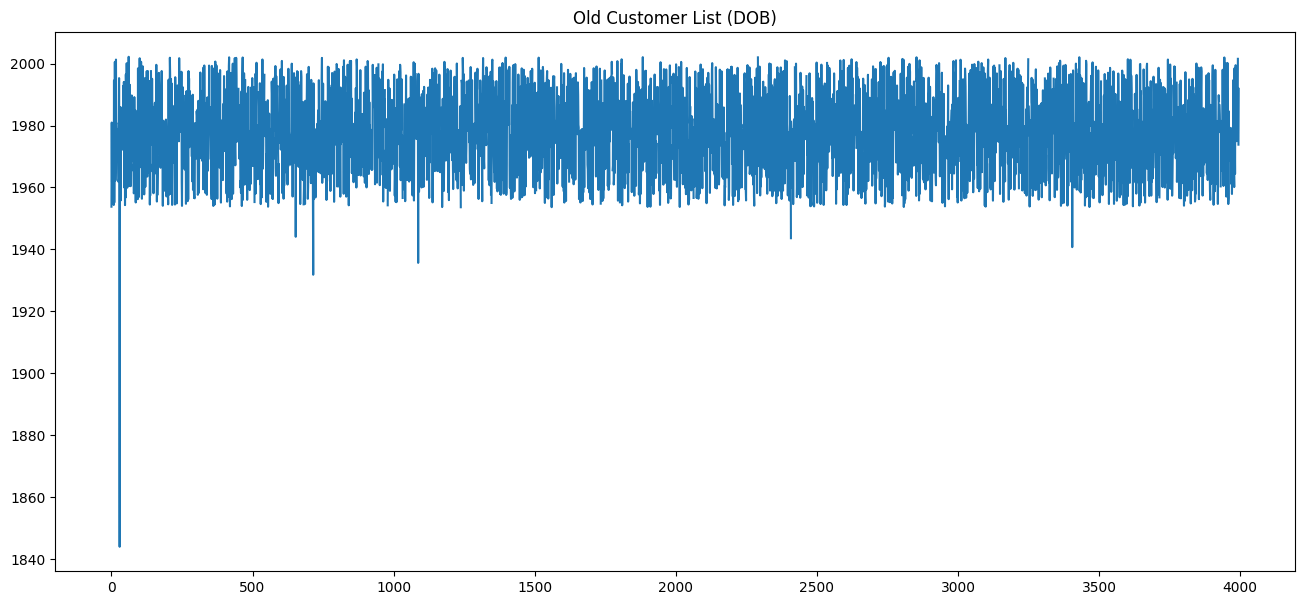

In [10]:
#line plot of the date of birth in old Customer list
OldCustomerList_df.DOB.plot(figsize=(16,7))
plt.title('Old Customer List (DOB)')
fig1 = plt.gcf()
fig1.savefig('old_DOB.png')
plt.show()

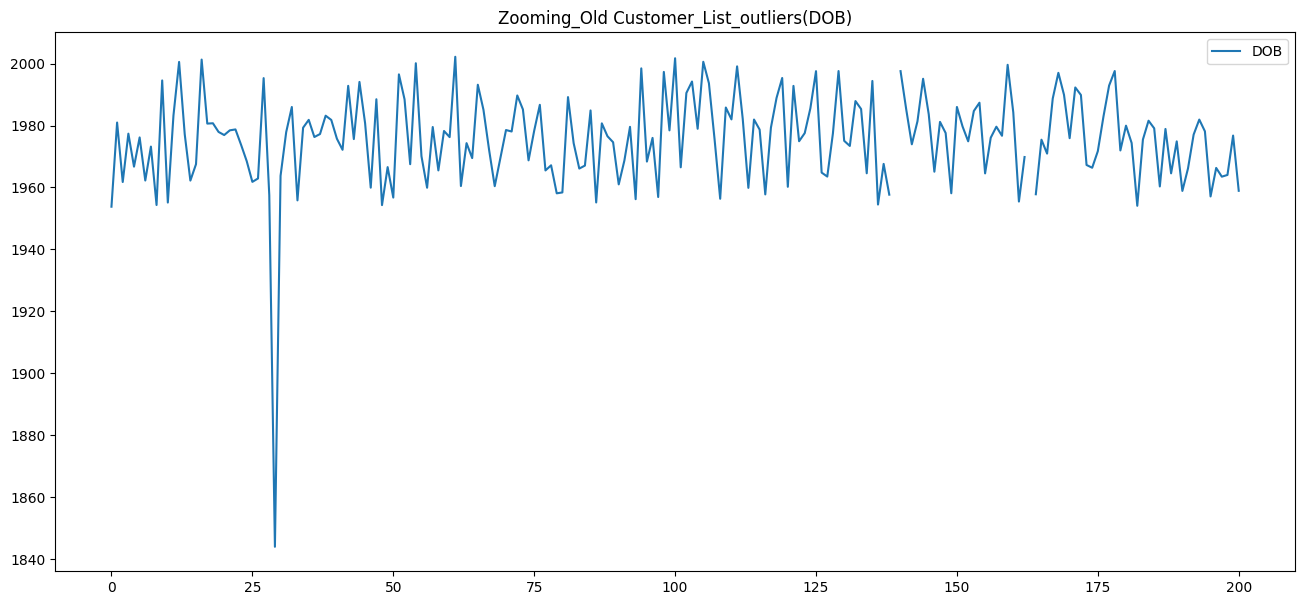

In [11]:
#zooming in to the spike in the plot. we can see the outlier and the missing values which is represented by a break in the line.
OldCustomerList_df.loc[:200, ['DOB']].plot(figsize=(16,7))
plt.title('Zooming_Old Customer_List_outliers(DOB)')
fig2 = plt.gcf()
fig2.savefig('old_DOB_zoom.png')
plt.show()

In [12]:
#checking the distribution at the outliers
OldCustomerList_df[['DOB', 'deceased_indicator']].value_counts().sort_index(level='DOB', ascending=True).head(10)

DOB         deceased_indicator
1843-12-21  N                     1
1931-10-23  N                     1
1935-08-22  N                     1
1940-09-22  N                     1
1943-08-11  N                     1
1944-01-24  N                     1
1953-08-09  N                     1
1953-08-17  N                     1
1953-08-31  N                     1
1953-09-05  N                     1
Name: count, dtype: int64

1939-05-20 20:39:58.158096704


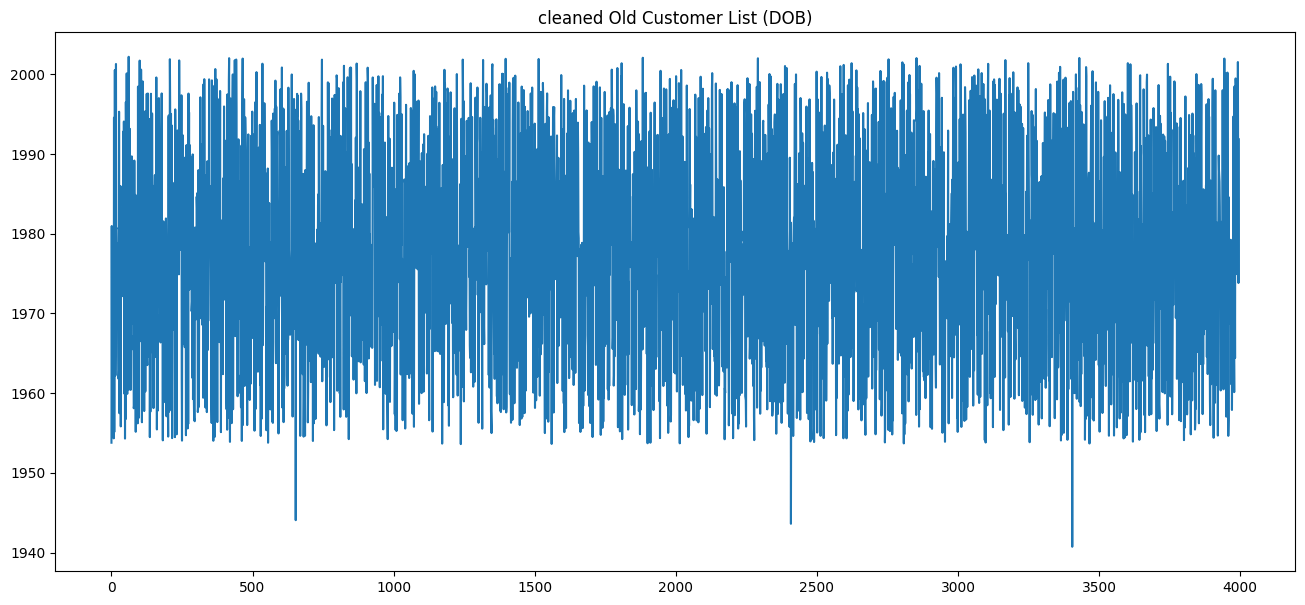

In [13]:
#5. cleaning invalid values and outliers
#the interquartile range is a good measure of centered dispersion and it is not sensitive to outliers
iqr = OldCustomerList_df.DOB.quantile(.25) - OldCustomerList_df.DOB.quantile(.75)
lowerlimit = OldCustomerList_df.DOB.mean()-2 * iqr
upperlimit = OldCustomerList_df.DOB.mean()+2 * iqr
print(upperlimit)

OldCustomerList_df['DOB'][OldCustomerList_df.DOB > upperlimit].plot(figsize=(16,7))
plt.title('cleaned Old Customer List (DOB)')
fig3 = plt.gcf()
fig3.savefig('clean_old_DOB.png')
plt.show()


OldCustomerList_df = OldCustomerList_df.drop(OldCustomerList_df[OldCustomerList_df.DOB < upperlimit].index)

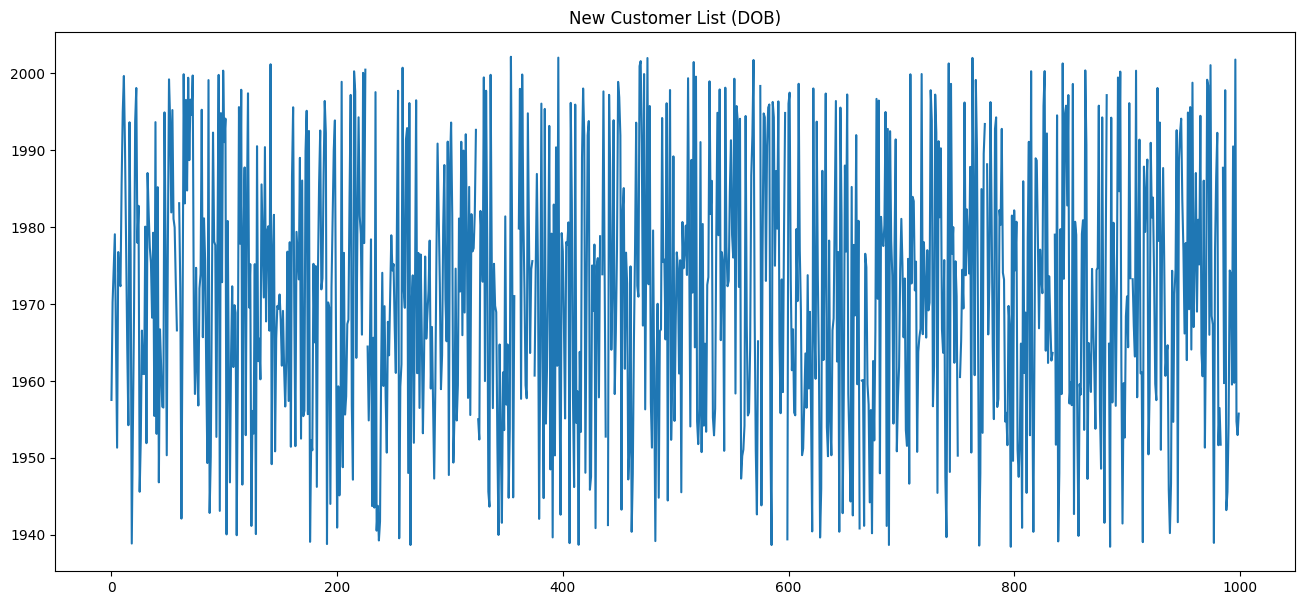

In [14]:
#line plot of the date of birth in old Customer list
NewCustomerList_df.DOB.plot(figsize=(16,7))
plt.title('New Customer List (DOB)')
fig4 = plt.gcf()
fig4.savefig('new_DOB.png')
plt.show()

1939-05-20 20:39:58.158096704


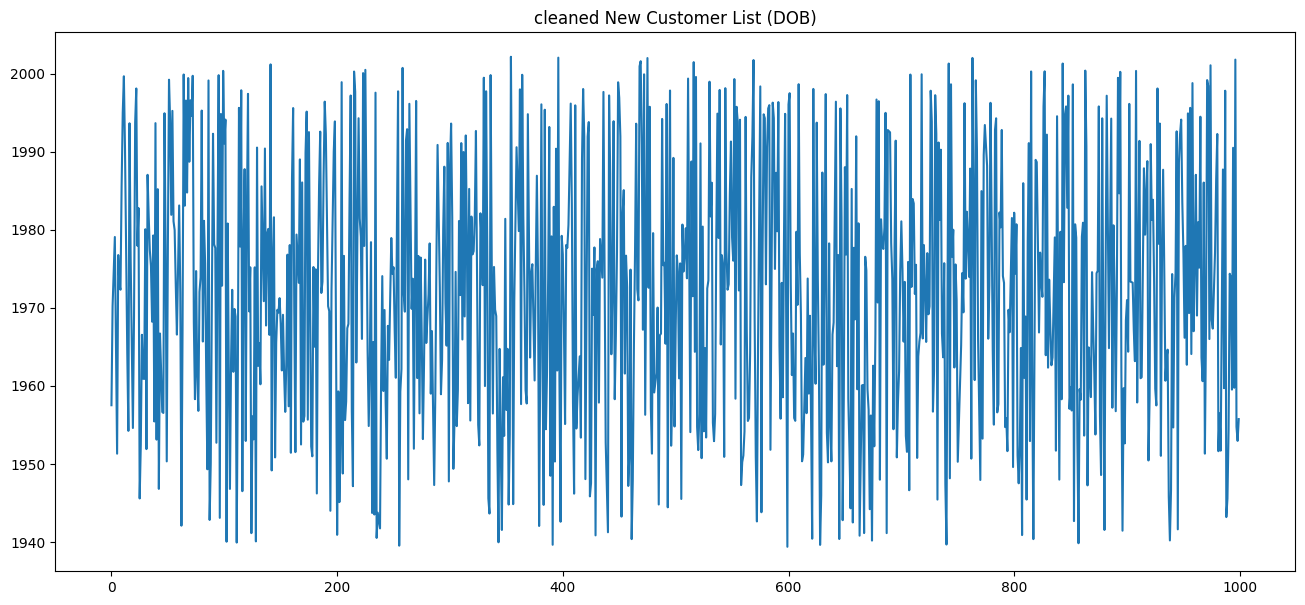

In [15]:
#cleaning outliers analytically
iqr = NewCustomerList_df.DOB.quantile(.25) -NewCustomerList_df.DOB.quantile(.75)
lowerlimit = NewCustomerList_df.DOB.mean()-2 * iqr
uppperlimit = NewCustomerList_df.DOB.mean()+2 * iqr
print(upperlimit)

NewCustomerList_df['DOB'][NewCustomerList_df.DOB > upperlimit].plot(figsize=(16,7))
plt.title('cleaned New Customer List (DOB)')
fig5 = plt.gcf()
fig5.savefig('clean_new_DOB.png')
plt.show()

NewCustomerList_df = NewCustomerList_df.drop(NewCustomerList_df[NewCustomerList_df.DOB < upperlimit].index)

In [16]:
#5. dropping invalid columns due to unclearity in the values and column name and inconsistency in the customer demographics dataset
print(OldCustomerList_df.default)
OldCustomerList_df.drop(['default'], axis=1, inplace=True)


print(NewCustomerList_df[['past_3_years_bike_related_purchases', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value']])
NewCustomerList_df.drop(columns=['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value'], inplace=True)

0                                                      "'
1                            <script>alert('hi')</script>
2       () { _; } >_[$($())] { touch /tmp/blns.shellsh...
3                                                     NIL
4                                                ðµ ð ð ð
                              ...                        
3991                                                 -100
3992                                             â¦testâ§
3993                                                  NaN
3994                               Â¡â¢Â£Â¢âÂ§Â¶â¢ÂªÂºââ 
3995                                                  0/0
Name: default, Length: 3993, dtype: object
     past_3_years_bike_related_purchases  Unnamed: 16  Unnamed: 17  \
0                                     86         0.56       0.7000   
1                                     69         0.89       0.8900   
2                                     10         1.01       1.0100   
3                                     6

In [17]:
OldCustomerList_df = OldCustomerList_df.reset_index(drop=True)

In [18]:
Transactions_df = Transactions_df.reset_index(drop=True)

In [19]:
NewCustomerList_df = NewCustomerList_df.reset_index(drop=True)

In [36]:
# score for Ordinal Encoding categorical values and imputing missing values in Transactions_df

#loading simpleimputer into a variable
Imputer = SimpleImputer()

#loading ordinal Encoder into a variable
ordinal_encoder = OrdinalEncoder()

#loading the y dot notation and the X features
y = Transactions_df.list_price
Transactions_predictors = Transactions_df.drop(['list_price'], axis=1)
Transactions_predictors['transaction_date'] = (pd.to_datetime(Transactions_predictors['transaction_date']) - pd.Timestamp('1970-01-01')) / pd.Timedelta('1D')
X = Transactions_predictors.copy()

#spliting the dataset into a trainig data and a validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 11 and 
                        X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]


# Preprocessing for numerical data
numerical_transformer = SimpleImputer()

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinalencoder', OrdinalEncoder())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(random_state=0))
                             ])
my_pipeline.fit(X_train, y_train)

prediction = my_pipeline.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Improved Transactions_df MAE:')
print(MAE)

Improved Transactions_df MAE:
4.943958280001487


In [45]:
# score for Ordinal Encoding in Transactions_df

#loading ordinal Encoder into a variable
ordinal_encoder = OrdinalEncoder()

#loading the y dot notation and the X features
y = OldCustomerList_df.past_3_years_bike_related_purchases
OldCustomerList_df_predictors = OldCustomerList_df.drop(['past_3_years_bike_related_purchases', 'gender'], axis=1)
OldCustomerList_df_predictors['DOB'] = (pd.to_datetime(OldCustomerList_df_predictors['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
X = OldCustomerList_df_predictors.copy()

#spliting the dataset into a trainig data and a validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

#definng the low cardinality columns to be encoded
categorical_cols = [cname for cname in X_train.columns 
                     if X_train[cname].nunique()<11 and X_train[cname].dtype == 'object']

#defining the numerical columns
numerical_cols = [cname for cname in X_train.columns 
                     if X_train[cname].dtype in ['int64', 'float64']]

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinalencoder', OrdinalEncoder())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


my_pipeline_1 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(random_state=0))
                             ])
my_pipeline_1.fit(X_train, y_train)

prediction1 = my_pipeline_1.predict(X_val)
MAE = mean_absolute_error(y_val, prediction1)
print('Improved OldCustomerList_df MAE:')
print(MAE)

Improved OldCustomerList_df MAE:
24.67705705705706


## FEATURE INSPECTION 

Now, that we have identified which method to use to clean our numerical and categorical values, taken care of inconsistent values, outliers, data types and invalid values. Next, I will like to create additional features that will boast our model performance.

Before the feature engineering, I will need to first idetify which features are importance using **SHAP(SHAPLEY ADDITIVE EXPLANATION) summarry plot to understand the impact of each feature. and dive more deeper using **SHAP(SHAPLEY ADDITIVE EXPLANATION) dependence contribution plot to show the distribution of effects.

Alright! let's play!

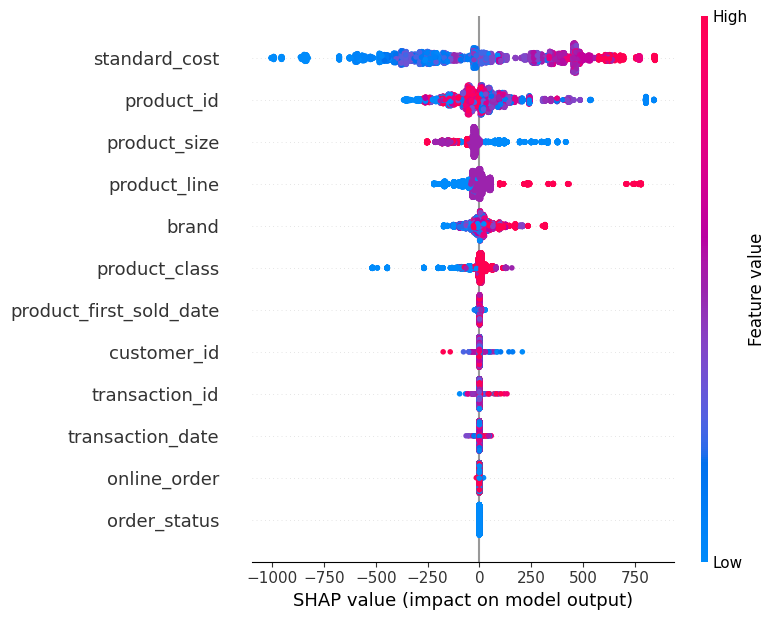

In [46]:
#loading ordinal Encoder into a variable
ordinal_encoder = OrdinalEncoder()

#loading the y dot notation and the X features
y = Transactions_df.list_price
Transactions_predictors = Transactions_df.drop(['list_price'], axis=1)
Transactions_predictors['transaction_date'] = (pd.to_datetime(Transactions_predictors['transaction_date']) - pd.Timestamp('1970-01-01')) / pd.Timedelta('1D')
Transactions_predictors['product_first_sold_date'] = (pd.to_datetime(Transactions_predictors['product_first_sold_date']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
X = Transactions_predictors.copy()

#spliting the dataset into a trainig data and a validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
   
#definng the low cardinality columns to be encoded
low_cardinality_cols = [cname for cname in X_train.columns 
                     if X_train[cname].nunique()<10 and X_train[cname].dtype == 'object']

#defining the numerical columns
numerical_col = [cname for cname in X_train.columns 
                     if X_train[cname].dtype in ['int64', 'float64']]

#joining the low cardinality columns and the numerical columns
feature_col = low_cardinality_cols + numerical_col

#re-defining the training and validation features
train_X_full = X_train[feature_col].copy()
val_X_full = X_val[feature_col].copy()

label_train_X = train_X_full.copy()
label_val_X = val_X_full.copy()

label_train_X[low_cardinality_cols] = ordinal_encoder.fit_transform(train_X_full[low_cardinality_cols])
label_val_X[low_cardinality_cols] = ordinal_encoder.transform(val_X_full[low_cardinality_cols])


#imputing the missing values in the training and validation data
Imput_train_X = pd.DataFrame(Imputer.fit_transform(label_train_X))
Imput_val_X = pd.DataFrame(Imputer.transform(label_val_X))

#putting back the column name as imputation removes coloumn names
Imput_train_X.columns = label_train_X.columns
Imput_val_X.columns = label_val_X.columns

my_model = RandomForestRegressor(n_estimators=50, random_state=0)

my_model.fit(Imput_train_X, y_train)

explainer = shap.TreeExplainer(my_model)

shap_values = explainer.shap_values(Imput_val_X)

shap.summary_plot(shap_values, Imput_val_X)


In [36]:
Imput_val_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_status             5000 non-null   float64
 1   brand                    5000 non-null   float64
 2   product_line             5000 non-null   float64
 3   product_class            5000 non-null   float64
 4   product_size             5000 non-null   float64
 5   transaction_id           5000 non-null   float64
 6   product_id               5000 non-null   float64
 7   customer_id              5000 non-null   float64
 8   transaction_date         5000 non-null   float64
 9   online_order             5000 non-null   float64
 10  standard_cost            5000 non-null   float64
 11  product_first_sold_date  5000 non-null   float64
dtypes: float64(12)
memory usage: 468.9 KB


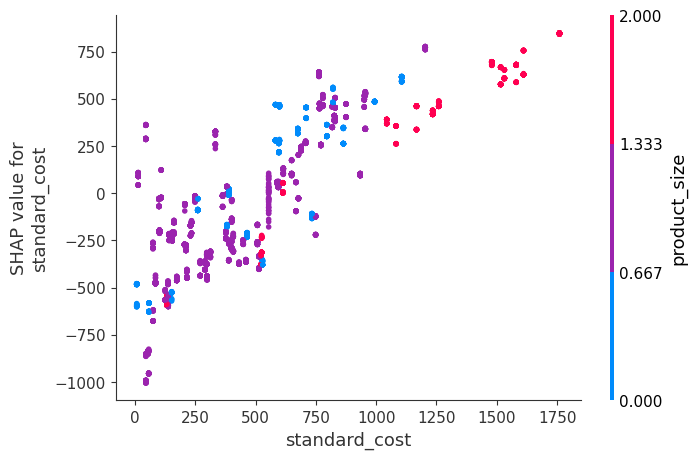

In [48]:
shap.dependence_plot('standard_cost', shap_values, Imput_val_X, interaction_index='product_size')

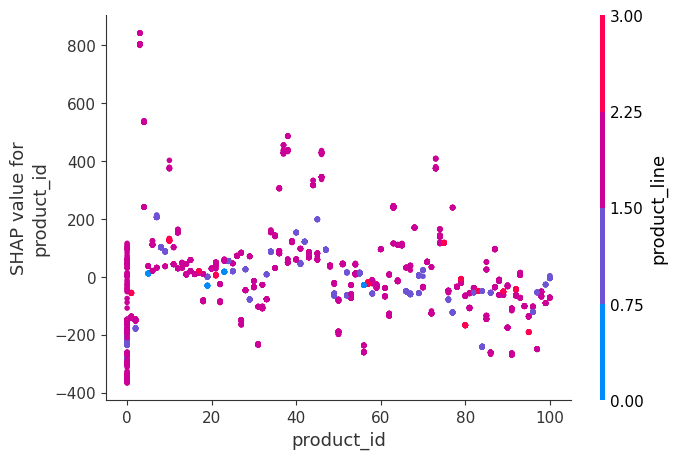

In [52]:
shap.dependence_plot('product_id', shap_values, Imput_val_X, interaction_index='product_line')

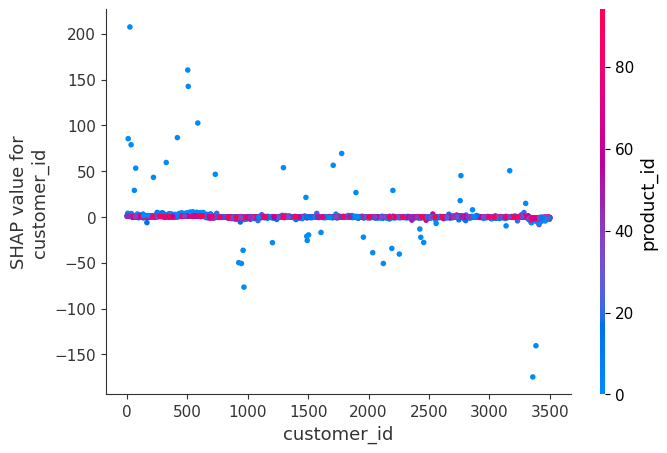

In [39]:
shap.dependence_plot('customer_id', shap_values, Imput_val_X)

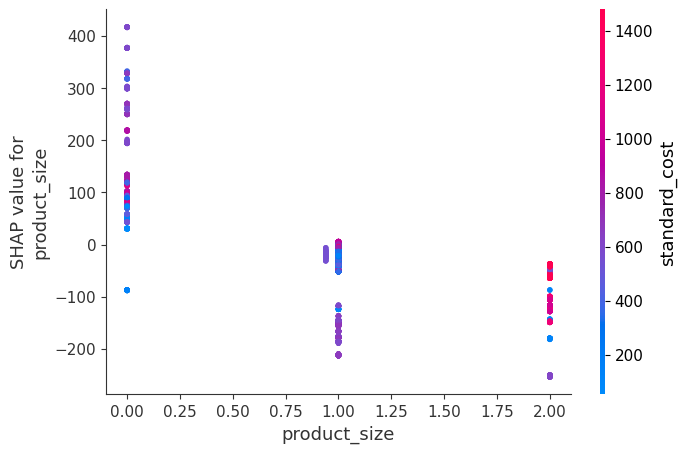

In [40]:
shap.dependence_plot('product_size', shap_values, Imput_val_X)

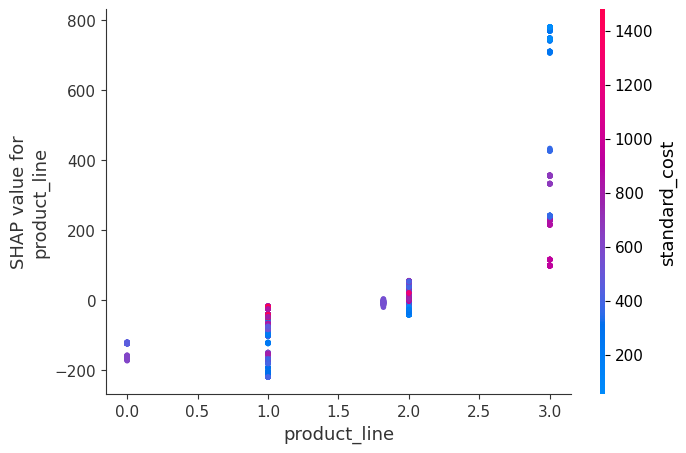

In [41]:
shap.dependence_plot('product_line', shap_values, Imput_val_X)

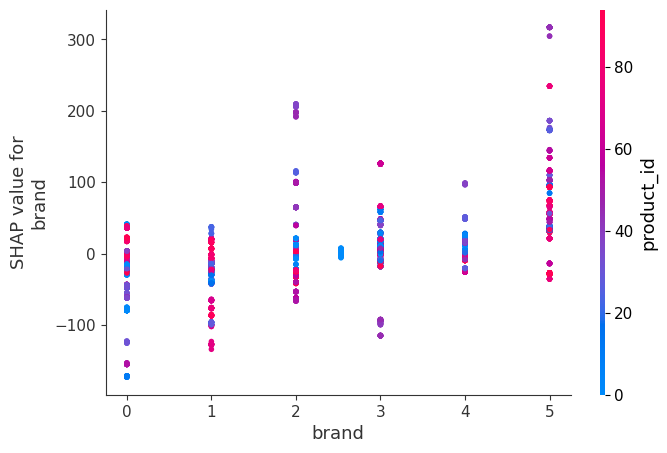

In [42]:
shap.dependence_plot('brand', shap_values, Imput_val_X)

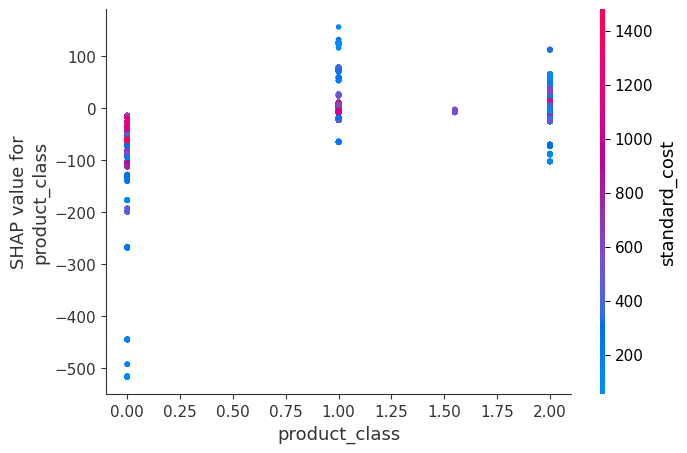

In [43]:
shap.dependence_plot('product_class', shap_values, Imput_val_X)

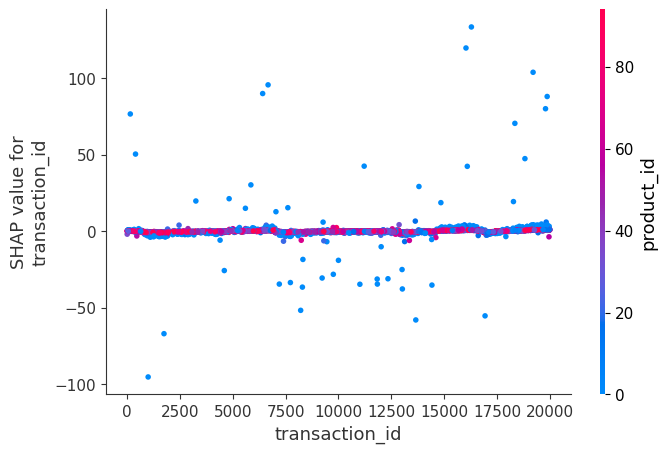

In [44]:
shap.dependence_plot('transaction_id', shap_values, Imput_val_X)

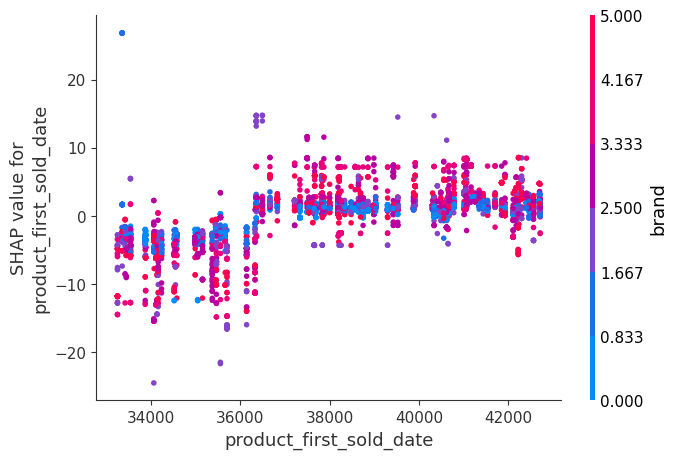

In [53]:
shap.dependence_plot('product_first_sold_date', shap_values, Imput_val_X)

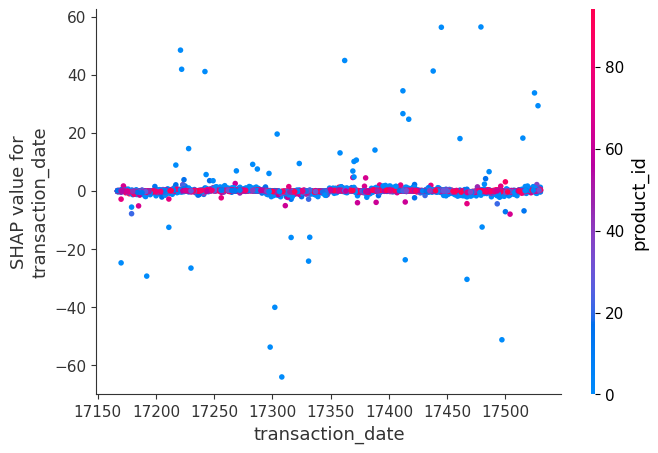

In [46]:
shap.dependence_plot('transaction_date', shap_values, Imput_val_X)

In [47]:
Imput_val_X.describe()

order_status        brand  product_line  product_class  product_size  \
count   5000.000000  5000.000000   5000.000000    5000.000000   5000.000000   
mean       0.009200     2.540114      1.819862       1.535077      0.950023   
std        0.095484     1.681121      0.554551       0.750537      0.577411   
min        0.000000     0.000000      0.000000       0.000000      0.000000   
25%        0.000000     1.000000      2.000000       1.000000      1.000000   
50%        0.000000     3.000000      2.000000       2.000000      1.000000   
75%        0.000000     4.000000      2.000000       2.000000      1.000000   
max        1.000000     5.000000      3.000000       2.000000      2.000000   

       transaction_id   product_id  customer_id  transaction_date  \
count     5000.000000  5000.000000  5000.000000       5000.000000   
mean     10063.945200    45.576000  1746.247000      17347.207600   
std       5756.416005    30.719918  1013.866913        106.004514   
min          9.000000     0.000000     1.000000      17167.000000   
25%       5164.000000    18.000000   865.750000      17255.000000   
50%       9946.500000    45.000000  1752.000000      17348.000000   
75%      15116.500000    72.000000  2629.250000      17440.000000   
max      19998.000000   100.000000  3500.000000      17530.000000   

       online_order  standard_cost  product_first_sold_date  
count   5000.000000    5000.000000              5000.000000  
mean       0.504484     561.639414             38236.507168  
std        0.495155     407.609996              2857.332290  
min        0.000000       7.210000             33259.000000  
25%        0.000000     215.140000             35667.000000  
50%        0.499186     513.850000             38216.000000  
75%        1.000000     795.100000             40779.000000  
max        1.000000    1759.850000             42710.000000

In [48]:
for col in Transactions_predictors.columns:
    if Transactions_predictors[col].dtype == 'object' and col != 'address':
        unique_values = Transactions_predictors[col].unique()
        print(f"Column '{col}': Unique values = {unique_values}")

Column 'order_status': Unique values = ['Approved' 'Cancelled']
Column 'brand': Unique values = ['Solex' 'Trek Bicycles' 'OHM Cycles' 'Norco Bicycles' 'Giant Bicycles'
 'WeareA2B' nan]
Column 'product_line': Unique values = ['Standard' 'Road' 'Mountain' 'Touring' nan]
Column 'product_class': Unique values = ['medium' 'low' 'high' nan]
Column 'product_size': Unique values = ['medium' 'large' 'small' nan]


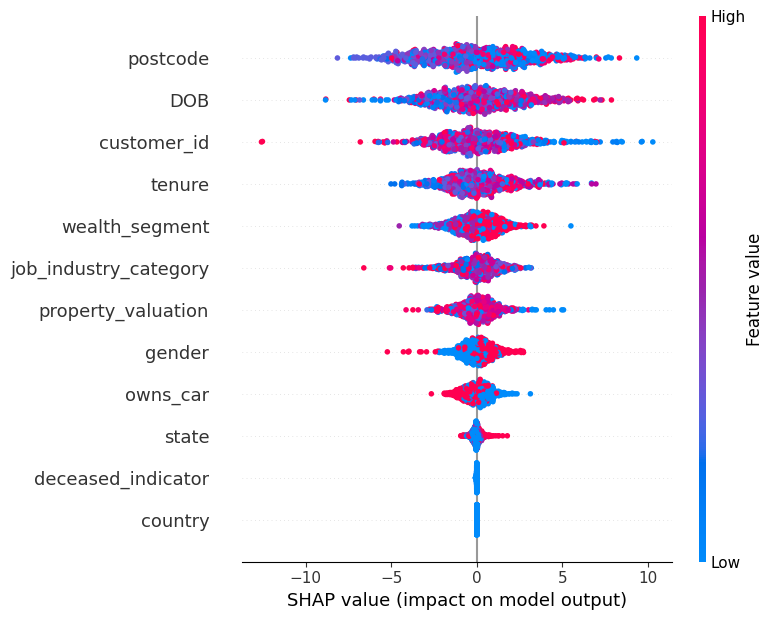

In [20]:
#loading ordinal Encoder into a variable
ordinal_encoder = OrdinalEncoder()
Imputer = SimpleImputer()

#loading the y dot notation and the X features
y = OldCustomerList_df.past_3_years_bike_related_purchases
OldCustomerList_df_predictors = OldCustomerList_df.drop(['past_3_years_bike_related_purchases'], axis=1)
OldCustomerList_df_predictors['DOB'] = (pd.to_datetime(OldCustomerList_df_predictors['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
X = OldCustomerList_df_predictors.copy()

#spliting the dataset into a trainig data and a validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

#definng the low cardinality columns to be encoded
low_cardinality_cols = [cname for cname in X_train.columns 
                     if X_train[cname].nunique()<10 and X_train[cname].dtype == 'object']

#defining the numerical columns
numerical_col = [cname for cname in X_train.columns 
                     if X_train[cname].dtype in ['int64', 'float64']]

#joining the low cardinality columns and the numerical columns
feature_col = low_cardinality_cols + numerical_col

#re-defining the training and validation features
train_X_full = X_train[feature_col].copy()
val_X_full = X_val[feature_col].copy()

label_train_X = train_X_full.copy()
label_val_X = val_X_full.copy()

label_train_X[low_cardinality_cols] = ordinal_encoder.fit_transform(train_X_full[low_cardinality_cols])
label_val_X[low_cardinality_cols] = ordinal_encoder.transform(val_X_full[low_cardinality_cols])

#imputing the missing values in the training and validation data
Imput_train_X = pd.DataFrame(Imputer.fit_transform(label_train_X))
Imput_val_X = pd.DataFrame(Imputer.transform(label_val_X))

#putting back the column name as imputation removes coloumn names
Imput_train_X.columns = label_train_X.columns
Imput_val_X.columns = label_val_X.columns

my_model = RandomForestRegressor(n_estimators=50, random_state=0)

my_model.fit(Imput_train_X, y_train)

explainer = shap.TreeExplainer(my_model)

shap_values = explainer.shap_values(Imput_val_X)

shap.summary_plot(shap_values, Imput_val_X)

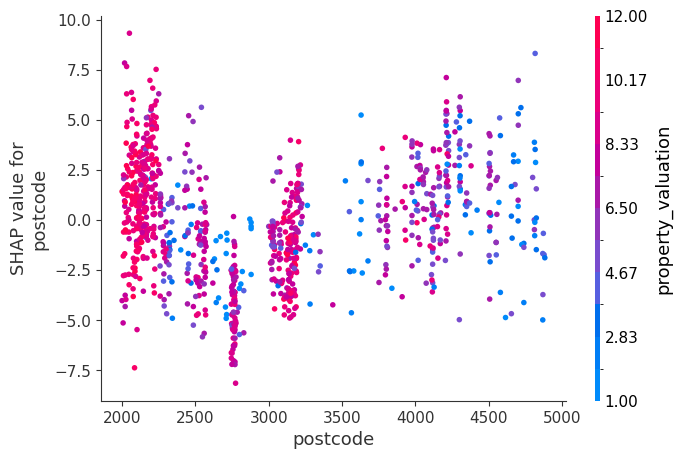

In [58]:
shap.dependence_plot('postcode', shap_values, Imput_val_X, interaction_index='property_valuation')

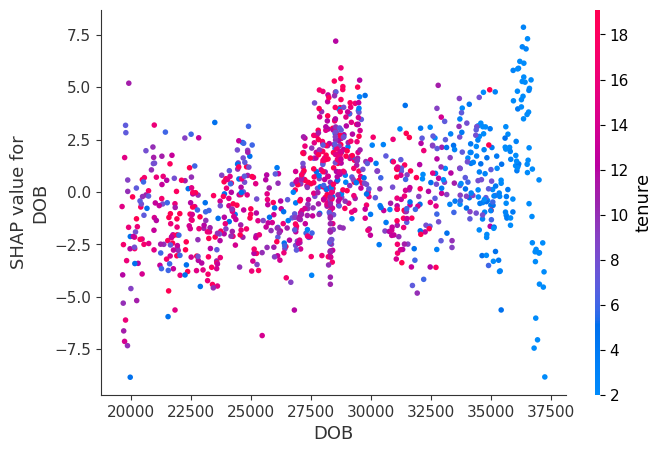

In [64]:
shap.dependence_plot('DOB', shap_values, Imput_val_X, interaction_index='tenure')


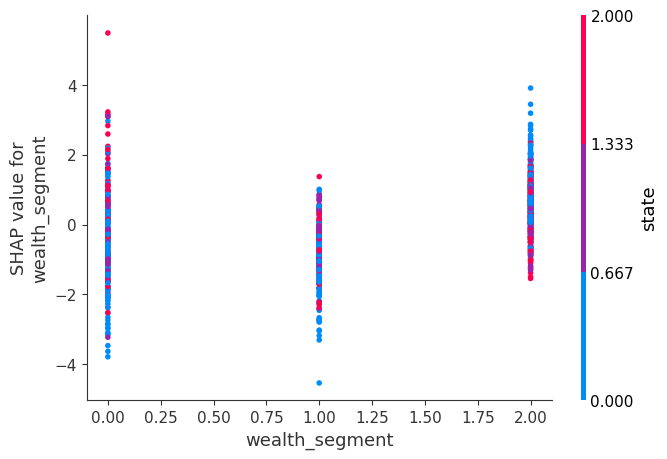

In [21]:
shap.dependence_plot('wealth_segment', shap_values, Imput_val_X)

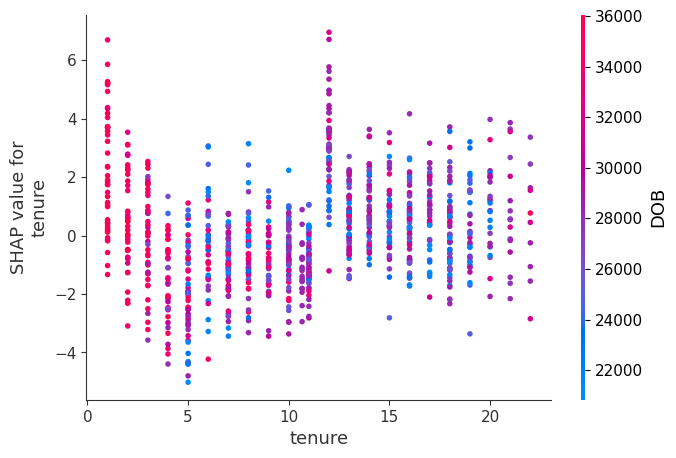

In [52]:
shap.dependence_plot('tenure', shap_values, Imput_val_X)

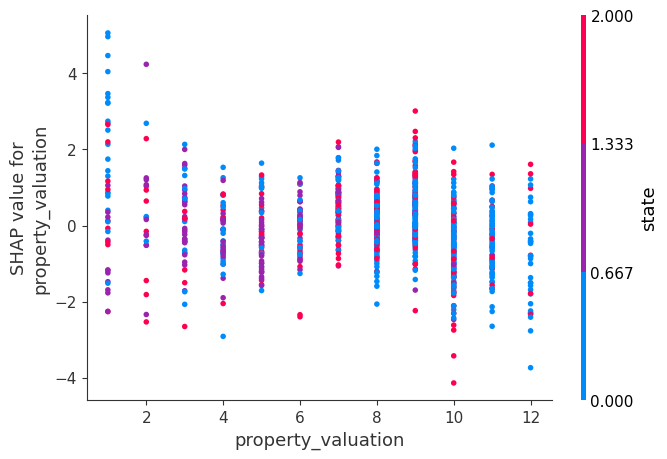

In [26]:
shap.dependence_plot('property_valuation', shap_values, Imput_val_X, interaction_index='state')

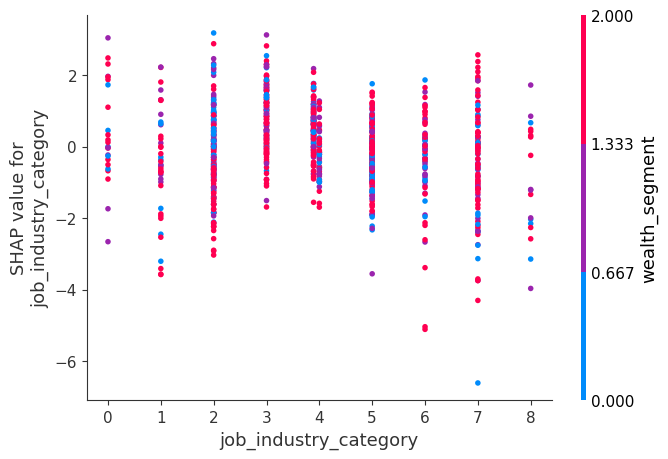

In [22]:
shap.dependence_plot('job_industry_category', shap_values, Imput_val_X, interaction_index='wealth_segment')

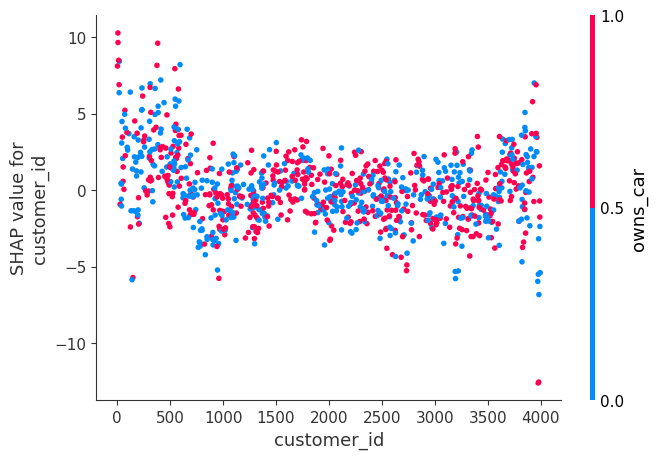

In [65]:
shap.dependence_plot('customer_id', shap_values, Imput_val_X, interaction_index = 'owns_car')

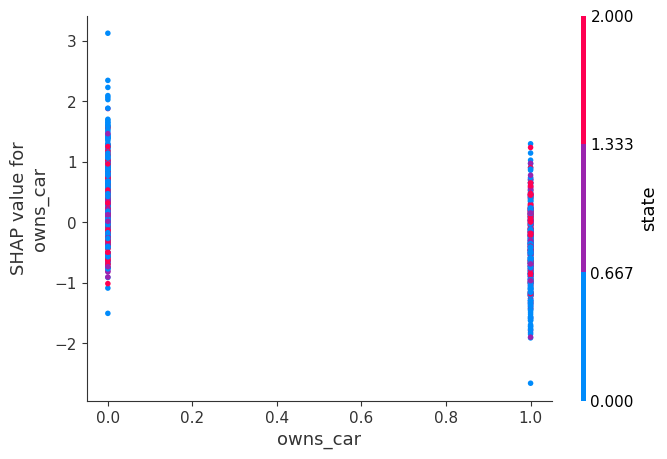

In [29]:
shap.dependence_plot('owns_car', shap_values, Imput_val_X)

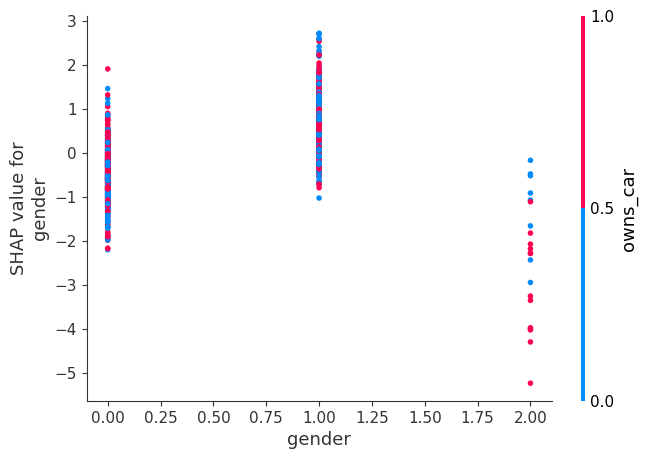

In [27]:
shap.dependence_plot('gender', shap_values, Imput_val_X, interaction_index = 'owns_car')

In [55]:
Imput_val_X.describe()

gender  job_industry_category  wealth_segment  deceased_indicator  \
count  999.000000             999.000000      999.000000               999.0   
mean     0.514515               3.934115        1.277277                 0.0   
std      0.540485               1.841241        0.813337                 0.0   
min      0.000000               0.000000        0.000000                 0.0   
25%      0.000000               2.000000        1.000000                 0.0   
50%      0.000000               3.890902        2.000000                 0.0   
75%      1.000000               5.000000        2.000000                 0.0   
max      2.000000               8.000000        2.000000                 0.0   

         owns_car       state  country  customer_id           DOB      tenure  \
count  999.000000  999.000000    999.0   999.000000    999.000000  999.000000   
mean     0.512513    0.712713      0.0  1999.582583  28432.150032   10.635564   
std      0.500094    0.842596      0.0  1176.656723   4569.585641    5.613709   
min      0.000000    0.000000      0.0     2.000000  19617.000000    1.000000   
25%      0.000000    0.000000      0.0   954.500000  24926.500000    6.000000   
50%      1.000000    0.000000      0.0  2018.000000  28351.000000   10.663251   
75%      1.000000    2.000000      0.0  3034.500000  31768.000000   15.000000   
max      1.000000    2.000000      0.0  3996.000000  37255.000000   22.000000   

          postcode  property_valuation  
count   999.000000          999.000000  
mean   2991.217217            7.582583  
std     840.602660            2.763007  
min    2000.000000            1.000000  
25%    2208.000000            6.000000  
50%    2767.000000            8.000000  
75%    3751.000000           10.000000  
max    4883.000000           12.000000

In [56]:
for col in OldCustomerList_df.columns:
    if OldCustomerList_df[col].dtype == 'object' and col not in ['first_name', 'last_name', 'job_title', 'address']:
        unique_values = OldCustomerList_df[col].unique()
        print(f"Column '{col}': Unique values = {unique_values}")

Column 'gender': Unique values = ['Female' 'Male' 'U']
Column 'job_industry_category': Unique values = ['Health' 'Financial Services' 'IT' nan 'Retail' 'Argiculture' 'Property'
 'Manufacturing' 'Telecommunications' 'Entertainment']
Column 'wealth_segment': Unique values = ['Mass Customer' 'Affluent Customer' 'High Net Worth']
Column 'deceased_indicator': Unique values = ['N' 'Y']
Column 'owns_car': Unique values = ['Yes' 'No']
Column 'state': Unique values = ['NSW' 'QLD' 'VIC']
Column 'country': Unique values = ['Australia']


## FEATURE ENGINEERING

we wil be using Princial Component Analysis unsupervised machine learning algorithm to add festures to our dataset
Princial Component Analysis.

In [40]:
Imputer = SimpleImputer()
#loading ordinal Encoder into a variable
ordinal_encoder = OrdinalEncoder()

#loading the y dot notation and the X features

Transactions_predictors = Transactions_df.copy()
Transactions_predictors['transaction_date'] = (pd.to_datetime(Transactions_predictors['transaction_date']) - pd.Timestamp('1970-01-01')) / pd.Timedelta('1D')
Transactions_predictors['product_first_sold_date'] = (pd.to_datetime(Transactions_predictors['product_first_sold_date']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
df = Transactions_predictors.copy()


#definng the low cardinality columns to be encoded
low_cardinality_cols = [cname for cname in df.columns 
                     if df[cname].nunique() < 10 and df[cname].dtype == 'object']

#defining the numerical columns
numerical_col = [cname for cname in df.columns 
                     if df[cname].dtype in ['int64', 'float64']]

#joining the low cardinality columns and the numerical columns
feature_col = low_cardinality_cols + numerical_col

#re-defining the dataframe
df_full =  df[feature_col].copy()

# Create a copy of df_full as label_df
label_df = df_full.copy()


label_df[low_cardinality_cols] = ordinal_encoder.fit_transform(df_full[low_cardinality_cols])



#imputing the missing values in the training and validation data
Imput_df = pd.DataFrame(Imputer.fit_transform(label_df))


#putting back the column name as imputation removes coloumn names
Imput_df.columns = df_full.columns



In [41]:
Imput_df.head()

order_status  brand  product_line  product_class  product_size  \
0           0.0    3.0           2.0            2.0           1.0   
1           0.0    4.0           2.0            2.0           0.0   
2           0.0    2.0           2.0            1.0           1.0   
3           0.0    1.0           2.0            2.0           1.0   
4           0.0    0.0           2.0            2.0           0.0   

   transaction_id  product_id  customer_id  transaction_date  online_order  \
0             1.0         2.0       2950.0           17222.0           0.0   
1             2.0         3.0       3120.0           17307.0           1.0   
2             3.0        37.0        402.0           17455.0           0.0   
3             4.0        88.0       3135.0           17409.0           0.0   
4             5.0        78.0        787.0           17440.0           1.0   

   list_price  standard_cost  product_first_sold_date  
0       71.49          53.62                  41245.0  
1     2091.47         388.92                  41701.0  
2     1793.43         248.82                  36361.0  
3     1198.46         381.10                  36145.0  
4     1765.30         709.48                  42226.0

In [42]:
features = ["standard_cost", "product_id", "customer_id", "product_line", "product_class", "brand", "product_size"]

X = Imput_df.copy()
y = X.pop('list_price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [43]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0 -0.861501 -1.343835  0.689761 -1.166054 -0.401250  0.701581 -0.710567
1 -1.507300 -0.935675  0.974499 -1.329157 -0.359270  0.757224  1.117074
2 -0.066282 -0.002108  0.697203  1.425152 -0.376079 -0.252844 -0.656837
3 -0.384804  1.245082 -0.330987 -1.416199  0.796559  0.063639 -0.945152
4 -0.557385  1.820275  0.431423  0.949637  1.432387  0.730161  0.500033

In [44]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

PC1       PC2       PC3       PC4       PC5       PC6  \
standard_cost  0.545908  0.248490 -0.360006 -0.009863 -0.100419  0.301687   
product_id    -0.149744  0.663788 -0.450073 -0.037846  0.286652 -0.488939   
customer_id    0.008955  0.045771  0.082038 -0.991969 -0.081229  0.016367   
product_line  -0.380214  0.428256 -0.095740  0.071542 -0.641892  0.450117   
product_class -0.368836 -0.236722 -0.475466 -0.086498  0.520177  0.549731   
brand         -0.378858 -0.438802 -0.432152 -0.037920 -0.413360 -0.404545   
product_size   0.505317 -0.252101 -0.488990 -0.020717 -0.218338 -0.034470   

                    PC7  
standard_cost  0.639873  
product_id    -0.108317  
customer_id   -0.015013  
product_line  -0.207649  
product_class -0.039791  
brand          0.375770  
product_size  -0.626658

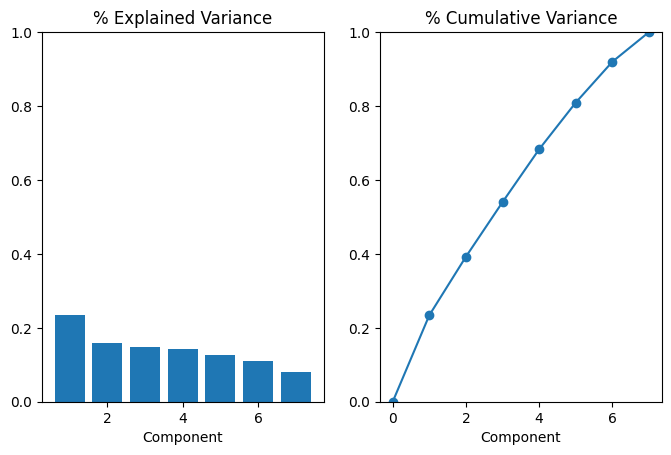

In [69]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

# Look at explained variance
plot_variance(pca);

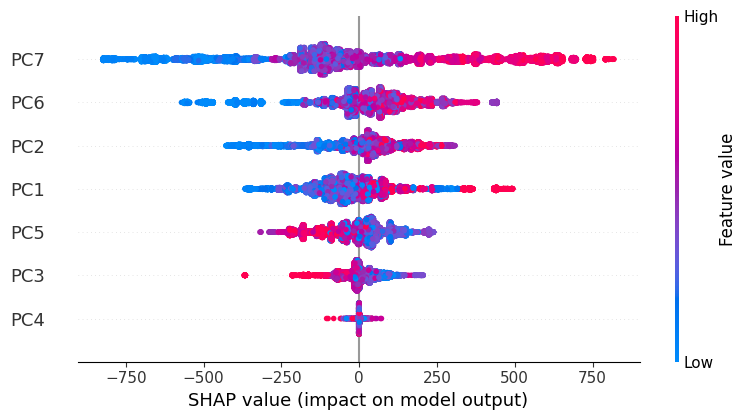

In [70]:
my_model = RandomForestRegressor(50, random_state=0)
my_model.fit(X_pca, y)
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(X_pca)
shap.summary_plot(shap_values, X_pca)

In [20]:
Transactions = Transactions_df.copy()

#loading simpleimputer into a variable
cat_Imputer = SimpleImputer(strategy='most_frequent')

#loading ordinal Encoder into a variable
num_Imputer = SimpleImputer(strategy='mean')

#loading the y dot notation and the X features

Transactions = Transactions.copy()


#definng the low cardinality columns to be encoded
cat_cols = [cname for cname in Transactions.columns 
                     if Transactions[cname].dtype == 'object']

#defining the numerical columns
num_col = [cname for cname in Transactions.columns 
                     if Transactions[cname].dtype in ['int64', 'float64']]

Transactions[cat_cols] = pd.DataFrame(cat_Imputer.fit_transform(Transactions[cat_cols]))
Transactions[num_col] = pd.DataFrame(num_Imputer.fit_transform(Transactions[num_col]))


In [21]:
Transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           19997 non-null  float64       
 1   product_id               19997 non-null  float64       
 2   customer_id              19997 non-null  float64       
 3   transaction_date         19997 non-null  datetime64[ns]
 4   online_order             19997 non-null  float64       
 5   order_status             19997 non-null  object        
 6   brand                    19997 non-null  object        
 7   product_line             19997 non-null  object        
 8   product_class            19997 non-null  object        
 9   product_size             19997 non-null  object        
 10  list_price               19997 non-null  float64       
 11  standard_cost            19997 non-null  float64       
 12  product_first_sold_date  19800 n

In [22]:
#pc5 product line(0.52) and product class(-0.64)
#pc6 product line(0.55), product class(0.45), and product_id(-0.49)
Transactions["product_class_line"] = Transactions.apply(lambda row: (
    f"{row['product_class']} with Standard" if row['product_line'] == 'Standard' 
    else (f"{row['product_class']} with Road" if row['product_line'] == 'Road' 
    else (f"{row['product_class']} with Mountain" if row['product_line'] == 'Mountain'
    else f"{row['product_class']} with Touring"))
), axis=1)

X_4 = pd.get_dummies(Transactions.product_class_line, prefix='CL')
X_4 = X_4.mul(Transactions.product_id, axis=0)
Transactions = Transactions.join(X_4)

#pc1 product size(0.51) and standard_cost(0.55)
#pc7 product size (-0.63) and standard_cost(0.64)
X_2 = pd.get_dummies(Transactions.product_size, prefix='size')
X_2 = X_2.mul(Transactions.standard_cost, axis=0)
Transactions = Transactions.join(X_2)

#pc2 product_id(0.66), product_line(0.43), brand(-0.44)
Transactions["product_brand_line"] = Transactions.apply(lambda row: (
    f"{row['brand']} with Standard" if row['product_line'] == 'Standard' 
    else (f"{row['brand']} with Road" if row['product_line'] == 'Road' 
    else (f"{row['brand']} with Mountain" if row['product_line'] == 'Mountain'
    else f"{row['brand']} with Touring"))
), axis=1)

X_1 = pd.get_dummies(Transactions.product_brand_line, prefix='BL')
X_1 = X_1.mul(Transactions.product_id, axis=0)
Transactions = Transactions.join(X_1)

#pc3 product size(-0.49), product_class(-0.47), and PRODUCT ID(-0.45)
Transactions["product_class_size"] = Transactions.apply(lambda row: (
    f"{row['product_class']} with medium" if row['product_size'] == 'medium' 
    else (f"{row['product_class']} with large" if row['product_size'] == 'large' 
    else f"{row['product_class']} with small")
), axis=1)

X_3 = pd.get_dummies(Transactions.product_class_size, prefix='CS')
X_3 = X_3.mul(Transactions.product_id, axis=0)
Transactions = Transactions.join(X_3)

#pc4 customer_id(0.99)
Transactions['transactionFreq'] = (Transactions.groupby('customer_id')['customer_id'].transform('count')/Transactions.customer_id.count())

In [23]:
X_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CS_high with large     19997 non-null  float64
 1   CS_high with medium    19997 non-null  float64
 2   CS_high with small     19997 non-null  float64
 3   CS_low with medium     19997 non-null  float64
 4   CS_low with small      19997 non-null  float64
 5   CS_medium with large   19997 non-null  float64
 6   CS_medium with medium  19997 non-null  float64
 7   CS_medium with small   19997 non-null  float64
dtypes: float64(8)
memory usage: 1.2 MB


In [71]:
Transactions["product_class_size"].value_counts()

product_class_size
medium with medium    8883
medium with large     3400
low with medium       2242
high with medium      2059
medium with small     1737
low with small         722
high with large        576
high with small        378
Name: count, dtype: int64

In [72]:
Transactions["product_brand_line"].value_counts()

product_brand_line
Solex with Standard             3705
Giant Bicycles with Standard    2554
WeareA2B with Standard          2520
OHM Cycles with Standard        2035
Norco Bicycles with Standard    1786
Trek Bicycles with Standard     1772
Trek Bicycles with Road          995
Norco Bicycles with Road         923
OHM Cycles with Road             778
WeareA2B with Touring            618
Giant Bicycles with Road         579
Solex with Road                  536
OHM Cycles with Touring          229
Trek Bicycles with Mountain      223
Solex with Touring               208
Norco Bicycles with Mountain     200
Giant Bicycles with Touring      179
WeareA2B with Road               157
Name: count, dtype: int64

In [73]:
X_1.nunique()

BL_Giant Bicycles with Road         7
BL_Giant Bicycles with Standard    22
BL_Giant Bicycles with Touring      3
BL_Norco Bicycles with Mountain     3
BL_Norco Bicycles with Road         9
BL_Norco Bicycles with Standard    16
BL_OHM Cycles with Road             8
BL_OHM Cycles with Standard        19
BL_OHM Cycles with Touring          3
BL_Solex with Road                  6
BL_Solex with Standard             29
BL_Solex with Touring               3
BL_Trek Bicycles with Mountain      3
BL_Trek Bicycles with Road          9
BL_Trek Bicycles with Standard     13
BL_WeareA2B with Road               3
BL_WeareA2B with Standard          22
BL_WeareA2B with Touring            7
dtype: int64

In [74]:
Transactions["product_size"].value_counts()

product_size
medium    13184
large      3976
small      2837
Name: count, dtype: int64

In [75]:
X_2.nunique()

size_large     20
size_medium    68
size_small     16
dtype: int64

In [76]:
Transactions["product_class_line"].value_counts()

product_class_line
medium with Standard    10156
medium with Road         2859
high with Standard       2627
low with Standard        1589
medium with Touring      1005
low with Road             723
low with Mountain         423
high with Road            386
low with Touring          229
Name: count, dtype: int64

In [77]:
X_4.nunique()

CL_high with Road           4
CL_high with Standard      25
CL_low with Mountain        5
CL_low with Road            9
CL_low with Standard       12
CL_low with Touring         3
CL_medium with Road        23
CL_medium with Standard    72
CL_medium with Touring     11
dtype: int64

In [78]:
print('Transactions', '\n', Transactions.select_dtypes('object').nunique())

Transactions 
 order_status           2
brand                  6
product_line           4
product_class          3
product_size           3
product_class_line     9
product_brand_line    18
product_class_size     8
dtype: int64


In [79]:
Transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   transaction_id                   19997 non-null  float64       
 1   product_id                       19997 non-null  float64       
 2   customer_id                      19997 non-null  float64       
 3   transaction_date                 19997 non-null  datetime64[ns]
 4   online_order                     19997 non-null  float64       
 5   order_status                     19997 non-null  object        
 6   brand                            19997 non-null  object        
 7   product_line                     19997 non-null  object        
 8   product_class                    19997 non-null  object        
 9   product_size                     19997 non-null  object        
 10  list_price                       19997 non-null  float64  

In [22]:
#loading the y dot notation and the X features
y = Transactions.list_price
Transactions_predictors = Transactions.drop(['list_price'], axis=1)
Transactions_predictors['transaction_date'] = (pd.to_datetime(Transactions_predictors['transaction_date']) - pd.Timestamp('1970-01-01')) / pd.Timedelta('1D')
Transactions_predictors['product_first_sold_date'] = (pd.to_datetime(Transactions_predictors['product_first_sold_date']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
X = Transactions_predictors.copy()


categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 11 and 
                        X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]


# Preprocessing for numerical data
numerical_transformer = SimpleImputer()

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinalencoder', OrdinalEncoder())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(random_state=0))
                             ])


# Compute cross-validation scores
scores = -1 * cross_val_score(my_pipeline, X, y,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')

print('Cross validation score for Transactions_Df', scores.mean())

#spliting the dataset into a trainig data and a validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

my_pipeline.fit(X_train, y_train)

prediction = my_pipeline.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Improved Transactions_df MAE:')
print(MAE)

Cross validation score for Transactions_Df 5.88850404386623
Improved Transactions_df MAE:
4.9260106600015305


In [31]:
my_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['transaction_id',
                                                   'product_id', 'customer_id',
                                                   'transaction_date',
                                                   'online_order',
                                                   'standard_cost',
                                                   'product_first_sold_date',
                                                   'PC7', 'PC6', 'PC2', 'PC1',
                                                   'PC5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['order_status', 'brand',
                                                   'product_line',
                                                   'product_class',
                                                   'product_size'])])),
                ('model',
                 RandomForestRegressor(n_estimators=50, random_state=0))])

In [25]:
#loading ordinal Encoder into a variable
ordinal_encoder = OrdinalEncoder()
Imputer = SimpleImputer()

#loading the y dot notation and the X features

OldCustomerList_df_predictors = OldCustomerList_df.copy()
OldCustomerList_df_predictors['DOB'] = (pd.to_datetime(OldCustomerList_df_predictors['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
df = OldCustomerList_df_predictors.copy()

#definng the low cardinality columns to be encoded
low_cardinality_cols = [cname for cname in df.columns 
                     if df[cname].nunique() < 10 and df[cname].dtype == 'object']

#defining the numerical columns
numerical_col = [cname for cname in df.columns 
                     if df[cname].dtype in ['int64', 'float64']]

#joining the low cardinality columns and the numerical columns
feature_col = low_cardinality_cols + numerical_col

#re-defining the dataframe
df_full =  df[feature_col].copy()

# Create a copy of df_full as label_df
label_df = df_full.copy()


label_df[low_cardinality_cols] = ordinal_encoder.fit_transform(df_full[low_cardinality_cols])



#imputing the missing values in the training and validation data
Imput_df = pd.DataFrame(Imputer.fit_transform(label_df))


#putting back the column name as imputation removes coloumn names
Imput_df.columns = df_full.columns

In [26]:
Imput_df.head()

gender  job_industry_category  wealth_segment  deceased_indicator  \
0     0.0               3.000000             2.0                 0.0   
1     1.0               2.000000             2.0                 0.0   
2     1.0               4.000000             2.0                 0.0   
3     0.0               3.903835             0.0                 0.0   
4     1.0               7.000000             1.0                 0.0   

   owns_car  state  country  customer_id  past_3_years_bike_related_purchases  \
0       1.0    0.0      0.0          1.0                                 93.0   
1       1.0    0.0      0.0          2.0                                 81.0   
2       0.0    1.0      0.0          4.0                                 33.0   
3       1.0    0.0      0.0          5.0                                 56.0   
4       1.0    2.0      0.0          6.0                                 35.0   

       DOB  tenure  postcode  property_valuation  
0  19642.0    11.0    2016.0                10.0  
1  29569.0    16.0    2153.0                10.0  
2  22555.0     7.0    4211.0                 9.0  
3  28256.0     8.0    2448.0                 4.0  
4  24364.0    13.0    3216.0                 9.0

In [83]:
features = ["postcode", "DOB", "customer_id", "tenure", "job_industry_category", "wealth_segment", "property_valuation", "owns_car", "gender"]

X = Imput_df.copy()
y = X.pop('past_3_years_bike_related_purchases')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

print(X_scaled.head())

   postcode       DOB  customer_id    tenure  job_industry_category  \
0 -1.147556 -1.914274    -1.736115  0.061447              -0.502518   
1 -0.985417  0.270847    -1.735248  0.955018              -1.058503   
2  1.450217 -1.273067    -1.733514 -0.653409               0.053466   
3 -0.636286 -0.018169    -1.732647 -0.474695               0.000000   
4  0.272639 -0.874872    -1.731780  0.418876               1.721420   

   wealth_segment  property_valuation  owns_car    gender  
0        0.903474            0.879765  0.987679 -0.944869  
1        0.903474            0.879765  0.987679  0.900953  
2        0.903474            0.525820 -1.012221  0.900953  
3       -1.522600           -1.243903  0.987679 -0.944869  
4       -0.309563            0.525820  0.987679  0.900953  


In [84]:
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.886150 -1.028458  0.740163 -0.850432 -1.086218 -1.050366 -1.302632   
1 -1.498448 -0.124461  2.054671 -0.498536 -0.895819  0.290383 -1.092301   
2  0.548421 -0.600577  1.236445 -1.368609  0.774205  0.550857 -0.933934   
3  0.321814  0.256229  0.868199  0.771940  0.295403 -2.184552 -0.947499   
4 -0.463548 -0.927258  0.623893  0.890179  0.957372  0.043055 -2.348895   

        PC8       PC9  
0 -1.341215  0.212262  
1  0.804207  0.087882  
2 -1.482183 -1.432650  
3 -0.390022  1.392194  
4 -0.336439 -0.576044

In [85]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

PC1       PC2       PC3       PC4       PC5  \
postcode               0.686411 -0.151170  0.037373  0.039704 -0.051434   
DOB                    0.174258  0.683903  0.002809 -0.029866  0.013749   
customer_id            0.033647  0.004156 -0.601359  0.305623 -0.232755   
tenure                -0.144816 -0.690492  0.057522 -0.009098 -0.005215   
job_industry_category  0.021452 -0.064592 -0.592179  0.189295  0.483819   
wealth_segment         0.007502 -0.031796 -0.163484 -0.634084 -0.491198   
property_valuation    -0.685734  0.164656 -0.017650 -0.009091  0.025875   
owns_car              -0.072259  0.016272  0.079562  0.620910 -0.639885   
gender                 0.020010  0.008226  0.499609  0.283791  0.239760   

                            PC6       PC7       PC8       PC9  
postcode              -0.043737 -0.012469 -0.021967 -0.705562  
DOB                   -0.003472 -0.037998  0.706658 -0.000649  
customer_id            0.371897  0.591302  0.041137 -0.000629  
tenure                -0.014256  0.034136  0.705212 -0.011705  
job_industry_category  0.133819 -0.596458  0.026731 -0.019862  
wealth_segment         0.470289 -0.327681 -0.002995 -0.017691  
property_valuation     0.019056  0.021397  0.009521 -0.707589  
owns_car              -0.098009 -0.427406  0.017006  0.025117  
gender                 0.781355 -0.036436 -0.005678 -0.004954

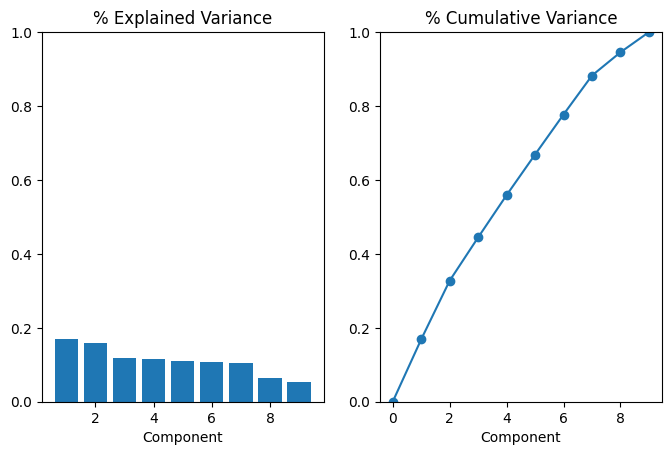

In [88]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs
plot_variance(pca);

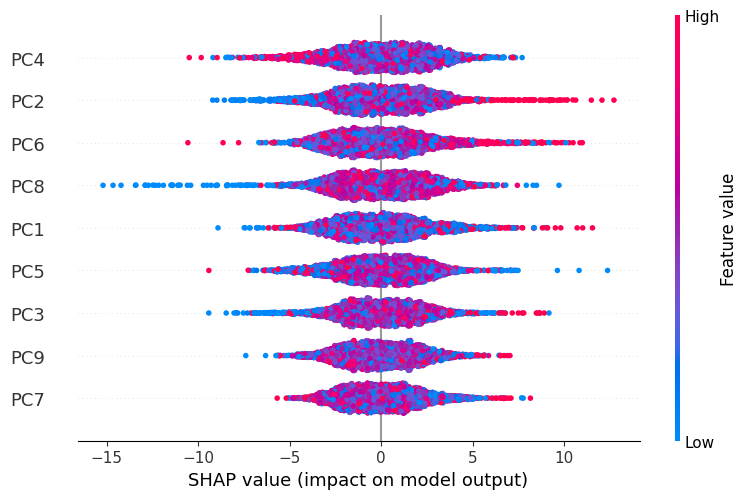

In [87]:
my_model = RandomForestRegressor(250, random_state=0)
my_model.fit(X_pca, y)
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(X_pca)
shap.summary_plot(shap_values, X_pca)

In [27]:
OldCustomerList = OldCustomerList_df.copy()
OldCustomerList['DOB'] = (pd.to_datetime(OldCustomerList_df['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')


#loading simpleimputer into a variable
cat_Imputer = SimpleImputer(strategy='most_frequent')

#loading ordinal Encoder into a variable
num_Imputer = SimpleImputer(strategy='mean')


#definng the low cardinality columns to be encoded
cat_cols = [cname for cname in OldCustomerList.columns 
                     if OldCustomerList[cname].dtype == 'object']

#defining the numerical columns
num_col = [cname for cname in OldCustomerList.columns 
                     if OldCustomerList[cname].dtype in ['int64', 'float64']]

OldCustomerList[cat_cols] = pd.DataFrame(cat_Imputer.fit_transform(OldCustomerList[cat_cols]))
OldCustomerList[num_col] = pd.DataFrame(num_Imputer.fit_transform(OldCustomerList[num_col]))
OldCustomerList['DOB'] = pd.to_datetime(OldCustomerList['DOB'], unit='D', origin='1900-01-01')

In [28]:
OldCustomerList.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3993 entries, 0 to 3992
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3993 non-null   float64       
 1   first_name                           3993 non-null   object        
 2   last_name                            3993 non-null   object        
 3   gender                               3993 non-null   object        
 4   past_3_years_bike_related_purchases  3993 non-null   float64       
 5   DOB                                  3993 non-null   datetime64[ns]
 6   job_title                            3993 non-null   object        
 7   job_industry_category                3993 non-null   object        
 8   wealth_segment                       3993 non-null   object        
 9   deceased_indicator                   3993 non-null   object        
 10  owns_car    

In [29]:
# Create a new column using the `apply` function
tenure_categories = [
	(0, 5, '0-4 years'),
	(5, 10, '5-9 years'),
	(10, 15, '10-14 years'),
	(15, 20, '15-19 years'),
	(20, 24, '20+ years')
]
OldCustomerList['tenure_category'] = OldCustomerList['tenure'].apply(lambda x: next((cat[2] for cat in tenure_categories if cat[0] <= x <= cat[1])))

# Calculate age
OldCustomerList['age'] = (pd.to_datetime('today') - OldCustomerList['DOB']).dt.days / 365.25

# Define age categories
age_categories = [
    (0, 18, 'Minor'),
    (18, 25, 'Young Adult'),
    (25, 45, 'Adult'),
    (45, 65, 'Middle-Aged'),
    (65, 100, 'Senior')
]

# Create age_category column
OldCustomerList['age_category'] = OldCustomerList['age'].apply(lambda x: next((cat[2] for cat in age_categories if cat[0] <= x <= cat[1])))

#PC2 DOB(0.68) and tenure(-o.69)
#PC8 DOB(0.71) and tenure(0.71)
OldCustomerList["demographic_age_tenure"] = OldCustomerList.apply(lambda row: (
    f"{row['age_category']} in 0-4 years" if row['tenure_category'] == '0-4 years' 
    else (f"{row['age_category']} in 5-9 years" if row['tenure_category'] == '5-9 years' 
    else (f"{row['age_category']} in 10-14 years" if row['tenure_category'] == '10-14 years'
    else (f"{row['age_category']} in 15-19 years" if row['tenure_category'] == '15-19 years'
    else f"{row['age_category']} in 20+ years")))
), axis=1)

#pc4 owns_car(0.62) and wealth segment(-0.63)
OldCustomerList["wealth_assets"] = OldCustomerList.apply(lambda row: (
    f"{row['wealth_segment']} with car" if row['owns_car'] == 'Yes' 
    else f"{row['wealth_segment']} without car"
), axis=1)
#PC6 wealth_segment(0.47) and gender(0.78)
OldCustomerList["wealth_gender"] = OldCustomerList.apply(lambda row: (
    f"{row['wealth_segment']} with Female" if row['gender'] == 'Female' 
    else (f"{row['wealth_segment']} with Male" if row['gender'] == 'Male' 
    else f"{row['wealth_segment']} with Unknown")      
), axis=1)

#PC1 postcode(0.68) and property_valuation(-0.69)
#PC9 postcode(-0.71) and property_valuation(-0.71)
#state is already category for postcode, run and check the table below, you can see how the postcode varies e.g from 2000 to 2880 is identified as NSW
OldCustomerList['property_valuation_category'] = pd.cut(OldCustomerList['property_valuation'], 
                                                        bins=[0, 2, 4, 6, 8, 10, 12], 
                                                        labels=['0-2', '3-4', '5-6', '7-8', '9-10', '11-12'], include_lowest=True).astype(object)

OldCustomerList["property_location"] = OldCustomerList.apply(lambda row: (
    f"{row['property_valuation_category']} in NSW" if row['state'] == 'NSW' 
    else (f"{row['property_valuation_category']} in VIC" if row['state'] == 'VIC' 
    else f"{row['property_valuation_category']} with QLD")      
), axis=1)
#PC5 job_industry_category(0.48), owns_car(-0.64) and wealth_segment(-0.49)
#PC7 Customer_id(0.59), job_industry_category(-0.60) and owns_car(0.43)
OldCustomerList["wealth_assests_job"] = OldCustomerList.apply(lambda row: (
    f"{row['wealth_assets']} in Manufacturing" if row['job_industry_category'] == 'Manufacturing' 
    else (f"{row['wealth_assets']} in Financial Services" if row['job_industry_category'] == 'Financial Services' 
    else (f"{row['wealth_assets']} in Health" if row['job_industry_category'] == 'Health' 
    else (f"{row['wealth_assets']} in Retail" if row['job_industry_category'] == 'Retail' 
    else (f"{row['wealth_assets']} in Property" if row['job_industry_category'] == 'Property'
    else (f"{row['wealth_assets']} in IT" if row['job_industry_category'] == 'IT' 
    else (f"{row['wealth_assets']} in Entertainment" if row['job_industry_category'] == 'Entertainment' 
    else (f"{row['wealth_assets']} in Argiculture" if row['job_industry_category'] == 'Argiculture' 
    else f"{row['wealth_assets']} in Telecommunications")))))))      
), axis=1)

#PC3 customer_id(0.60), job_industry_category(-0.59) AND gender(0.50)
OldCustomerList["job_gender"] = OldCustomerList_df.apply(lambda row: (
    f"{row['job_industry_category']} with Female" if row['gender'] == 'Female' 
    else (f"{row['job_industry_category']} with Male" if row['gender'] == 'Male' 
    else f"{row['job_industry_category']} with Unknown")      
), axis=1)

In [30]:
Table8 = OldCustomerList[["postcode", 'state']].value_counts().sort_index(level='state', ascending=True)
Table8.to_csv('table9.csv')

In [101]:
OldCustomerList["demographic_age_tenure"].value_counts()

demographic_age_tenure
Middle-Aged in 10-14 years    700
Adult in 0-4 years            568
Middle-Aged in 15-19 years    557
Middle-Aged in 5-9 years      546
Adult in 5-9 years            397
Adult in 10-14 years          261
Adult in 15-19 years          186
Middle-Aged in 0-4 years      177
Young Adult in 0-4 years      118
Senior in 10-14 years         117
Senior in 15-19 years         115
Senior in 5-9 years           112
Middle-Aged in 20+ years       62
Adult in 20+ years             47
Senior in 0-4 years            30
Name: count, dtype: int64

In [43]:
OldCustomerList["wealth_gender"].value_counts()

wealth_gender
Mass Customer with Female         1041
Mass Customer with Male            909
High Net Worth with Female         514
Affluent Customer with Female      481
High Net Worth with Male           481
Affluent Customer with Male        480
Mass Customer with Unknown          46
High Net Worth with Unknown         25
Affluent Customer with Unknown      16
Name: count, dtype: int64

In [44]:
OldCustomerList["property_location"].value_counts()

property_location
9-10 in NSW       841
7-8 in NSW        546
11-12 in NSW      387
7-8 in VIC        329
9-10 in VIC       289
7-8 with QLD      261
3-4 with QLD      191
5-6 with QLD      171
5-6 in NSW        146
5-6 in VIC        146
3-4 in NSW        115
0-2 with QLD      114
0-2 in NSW        102
3-4 in VIC         93
9-10 with QLD      92
11-12 in VIC       82
0-2 in VIC         81
11-12 with QLD      7
Name: count, dtype: int64

In [45]:
OldCustomerList["wealth_assests_job"].value_counts()

wealth_assests_job
Unknown                                                655
Mass Customer without car in Manufacturing             206
Mass Customer with car in Financial Services           202
Mass Customer with car in Manufacturing                198
Mass Customer without car in Financial Services        179
Mass Customer without car in Health                    161
Mass Customer with car in Health                       152
Affluent Customer with car in Manufacturing            115
Affluent Customer without car in Manufacturing         109
High Net Worth with car in Financial Services          106
Affluent Customer with car in Financial Services       106
High Net Worth without car in Financial Services        98
Mass Customer without car in Retail                     90
Mass Customer with car in Retail                        87
High Net Worth with car in Manufacturing                86
High Net Worth without car in Manufacturing             85
Affluent Customer without car in Fina

In [68]:
OldCustomerList["job_gender"].value_counts()

job_gender
Manufacturing with Female          425
Financial Services with Female     391
Financial Services with Male       375
Manufacturing with Male            371
nan with Female                    349
nan with Male                      306
Health with Female                 303
Health with Male                   293
Retail with Female                 183
Retail with Male                   173
Property with Female               144
Property with Male                 122
IT with Female                      78
IT with Male                        72
IT with Unknown                     71
Entertainment with Male             69
Entertainment with Female           67
Argiculture with Female             57
Argiculture with Male               56
Telecommunications with Female      39
Telecommunications with Male        33
Financial Services with Unknown      7
Health with Unknown                  6
Manufacturing with Unknown           3
Name: count, dtype: int64

In [103]:
OldCustomerList.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3993 entries, 0 to 3992
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3993 non-null   float64       
 1   first_name                           3993 non-null   object        
 2   last_name                            3993 non-null   object        
 3   gender                               3993 non-null   object        
 4   past_3_years_bike_related_purchases  3993 non-null   float64       
 5   DOB                                  3993 non-null   datetime64[ns]
 6   job_title                            3993 non-null   object        
 7   job_industry_category                3993 non-null   object        
 8   wealth_segment                       3993 non-null   object        
 9   deceased_indicator                   3993 non-null   object        
 10  owns_car    

In [102]:
print('OldCustomerList', '\n', OldCustomerList.select_dtypes('object').nunique())

OldCustomerList 
 first_name                     3134
last_name                      3718
gender                            3
job_title                       195
job_industry_category             9
wealth_segment                    3
deceased_indicator                2
owns_car                          2
address                        3990
state                             3
country                           1
tenure_category                   5
age_category                      4
demographic_age_tenure           15
wealth_assets                     6
wealth_gender                     9
property_valuation_category       6
property_location                18
wealth_assests_job               54
job_gender                       24
dtype: int64


In [28]:
#loading the y dot notation and the X features
y = OldCustomerList.past_3_years_bike_related_purchases
OldCustomerList_predictors = OldCustomerList.drop(['past_3_years_bike_related_purchases'], axis=1)
OldCustomerList_predictors['DOB'] = (pd.to_datetime(OldCustomerList_predictors['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
X = OldCustomerList_predictors.copy()



categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 56 and 
                        X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]


# Preprocessing for numerical data
numerical_transformer = SimpleImputer()

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinalencoder', OrdinalEncoder())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=500, random_state=0))
                             ])

# Compute cross-validation scores
scores = -1 * cross_val_score(my_pipeline, X, y,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')

print('Cross validation score for Transactions_Df', scores.mean())

#spliting the dataset into a trainig data and a validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

my_pipeline.fit(X_train, y_train)

prediction = my_pipeline.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Improved Transactions_df MAE:')
print(MAE)

Cross validation score for Transactions_Df 25.225097957660108
Improved Transactions_df MAE:
24.751371371371373


In [52]:
NewCustomerList = NewCustomerList_df.copy()
NewCustomerList['DOB'] = (pd.to_datetime(NewCustomerList_df['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')


#loading simpleimputer into a variable
cat_Imputer = SimpleImputer(strategy='most_frequent')

#loading ordinal Encoder into a variable
num_Imputer = SimpleImputer(strategy='mean')


#definng the low cardinality columns to be encoded
cat_cols = [cname for cname in NewCustomerList.columns 
                     if NewCustomerList[cname].dtype == 'object']

#defining the numerical columns
num_col = [cname for cname in NewCustomerList.columns 
                     if NewCustomerList[cname].dtype in ['int64', 'float64']]

NewCustomerList[cat_cols] = pd.DataFrame(cat_Imputer.fit_transform(NewCustomerList[cat_cols]))
NewCustomerList[num_col] = pd.DataFrame(num_Imputer.fit_transform(NewCustomerList[num_col]))
NewCustomerList['DOB'] = pd.to_datetime(NewCustomerList['DOB'], unit='D', origin='1900-01-01')

In [53]:
NewCustomerList.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           984 non-null    object        
 1   last_name                            984 non-null    object        
 2   gender                               984 non-null    object        
 3   past_3_years_bike_related_purchases  984 non-null    float64       
 4   DOB                                  984 non-null    datetime64[ns]
 5   job_title                            984 non-null    object        
 6   job_industry_category                984 non-null    object        
 7   wealth_segment                       984 non-null    object        
 8   deceased_indicator                   984 non-null    object        
 9   owns_car                             984 non-null    object        
 10  tenure        

In [54]:
# Create a new column using the `apply` function
tenure_categories = [
	(0, 5, '0-4 years'),
	(5, 10, '5-9 years'),
	(10, 15, '10-14 years'),
	(15, 20, '15-19 years'),
	(20, 24, '20+ years')
]
NewCustomerList['tenure_category'] = NewCustomerList['tenure'].apply(lambda x: next((cat[2] for cat in tenure_categories if cat[0] <= x <= cat[1])))

# Calculate age
NewCustomerList['age'] = (pd.to_datetime('today') - NewCustomerList['DOB']).dt.days / 365.25

# Define age categories
age_categories = [
    (0, 18, 'Minor'),
    (18, 25, 'Young Adult'),
    (25, 45, 'Adult'),
    (45, 65, 'Middle-Aged'),
    (65, 100, 'Senior')
]

# Create age_category column
NewCustomerList['age_category'] = NewCustomerList['age'].apply(lambda x: next((cat[2] for cat in age_categories if cat[0] <= x <= cat[1])))

#PC2 DOB(0.68) and tenure(-o.69)
#PC8 DOB(0.71) and tenure(0.71)
NewCustomerList["demographic_age_tenure"] = NewCustomerList.apply(lambda row: (
    f"{row['age_category']} in 0-4 years" if row['tenure_category'] == '0-4 years' 
    else (f"{row['age_category']} in 5-9 years" if row['tenure_category'] == '5-9 years' 
    else (f"{row['age_category']} in 10-14 years" if row['tenure_category'] == '10-14 years'
    else (f"{row['age_category']} in 15-19 years" if row['tenure_category'] == '15-19 years'
    else f"{row['age_category']} in 20+ years")))
), axis=1)

#pc4 owns_car(0.62) and wealth segment(-0.63)
NewCustomerList["wealth_assets"] = NewCustomerList.apply(lambda row: (
    f"{row['wealth_segment']} with car" if row['owns_car'] == 'Yes' 
    else f"{row['wealth_segment']} without car"
), axis=1)
#PC6 wealth_segment(0.47) and gender(0.78)
NewCustomerList["wealth_gender"] = NewCustomerList.apply(lambda row: (
    f"{row['wealth_segment']} with Female" if row['gender'] == 'Female' 
    else (f"{row['wealth_segment']} with Male" if row['gender'] == 'Male' 
    else f"{row['wealth_segment']} with Unknown")      
), axis=1)

#PC1 postcode(0.68) and property_valuation(-0.69)
#PC9 postcode(-0.71) and property_valuation(-0.71)
#state is already category for postcode, run and check the table below, you can see how the postcode varies e.g from 2000 to 2880 is identified as NSW
NewCustomerList['property_valuation_category'] = pd.cut(NewCustomerList['property_valuation'], 
                                                        bins=[0, 2, 4, 6, 8, 10, 12], 
                                                        labels=['0-2', '3-4', '5-6', '7-8', '9-10', '11-12'], include_lowest=True).astype(object)

NewCustomerList["property_location"] = NewCustomerList.apply(lambda row: (
    f"{row['property_valuation_category']} in NSW" if row['state'] == 'NSW' 
    else (f"{row['property_valuation_category']} in VIC" if row['state'] == 'VIC' 
    else f"{row['property_valuation_category']} with QLD")      
), axis=1)
#PC5 job_industry_category(0.48), owns_car(-0.64) and wealth_segment(-0.49)
#PC7 Customer_id(0.59), job_industry_category(-0.60) and owns_car(0.43)
NewCustomerList["wealth_assests_job"] = NewCustomerList.apply(lambda row: (
    f"{row['wealth_assets']} in Manufacturing" if row['job_industry_category'] == 'Manufacturing' 
    else (f"{row['wealth_assets']} in Financial Services" if row['job_industry_category'] == 'Financial Services' 
    else (f"{row['wealth_assets']} in Health" if row['job_industry_category'] == 'Health' 
    else (f"{row['wealth_assets']} in Retail" if row['job_industry_category'] == 'Retail' 
    else (f"{row['wealth_assets']} in Property" if row['job_industry_category'] == 'Property'
    else (f"{row['wealth_assets']} in IT" if row['job_industry_category'] == 'IT' 
    else (f"{row['wealth_assets']} in Entertainment" if row['job_industry_category'] == 'Entertainment' 
    else (f"{row['wealth_assets']} in Argiculture" if row['job_industry_category'] == 'Argiculture' 
    else f"{row['wealth_assets']} in Telecommunications")))))))      
), axis=1)

#PC3 customer_id(0.60), job_industry_category(-0.59) AND gender(0.50)
NewCustomerList["job_gender"] = NewCustomerList_df.apply(lambda row: (
    f"{row['job_industry_category']} with Female" if row['gender'] == 'Female' 
    else (f"{row['job_industry_category']} with Male" if row['gender'] == 'Male' 
    else f"{row['job_industry_category']} with Unknown")      
), axis=1)

In [32]:
print('NewCustomerList', '\n', NewCustomerList.select_dtypes('object').nunique())

NewCustomerList 
 first_name                     927
last_name                      946
gender                           3
job_title                      183
job_industry_category            9
wealth_segment                   3
deceased_indicator               1
owns_car                         2
address                        984
state                            3
country                          1
tenure_category                  5
age_category                     4
demographic_age_tenure          18
wealth_assets                    6
wealth_gender                    9
property_valuation_category      6
property_location               18
wealth_assests_job              54
job_gender                      23
dtype: int64


In [33]:
NewCustomerList.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           984 non-null    object        
 1   last_name                            984 non-null    object        
 2   gender                               984 non-null    object        
 3   past_3_years_bike_related_purchases  984 non-null    float64       
 4   DOB                                  984 non-null    datetime64[ns]
 5   job_title                            984 non-null    object        
 6   job_industry_category                984 non-null    object        
 7   wealth_segment                       984 non-null    object        
 8   deceased_indicator                   984 non-null    object        
 9   owns_car                             984 non-null    object        
 10  tenure        

## DATA VIZUALIZATION OF FINDINGS

In [110]:
Transactions['transactionFreq'].value_counts()

transactionFreq
0.00030    3414
0.00035    3332
0.00025    3005
0.00040    2488
0.00020    1996
0.00045    1863
0.00050    1120
0.00015    1080
0.00055     660
0.00010     404
0.00060     336
0.00065     208
0.00005      49
0.00070      42
Name: count, dtype: int64

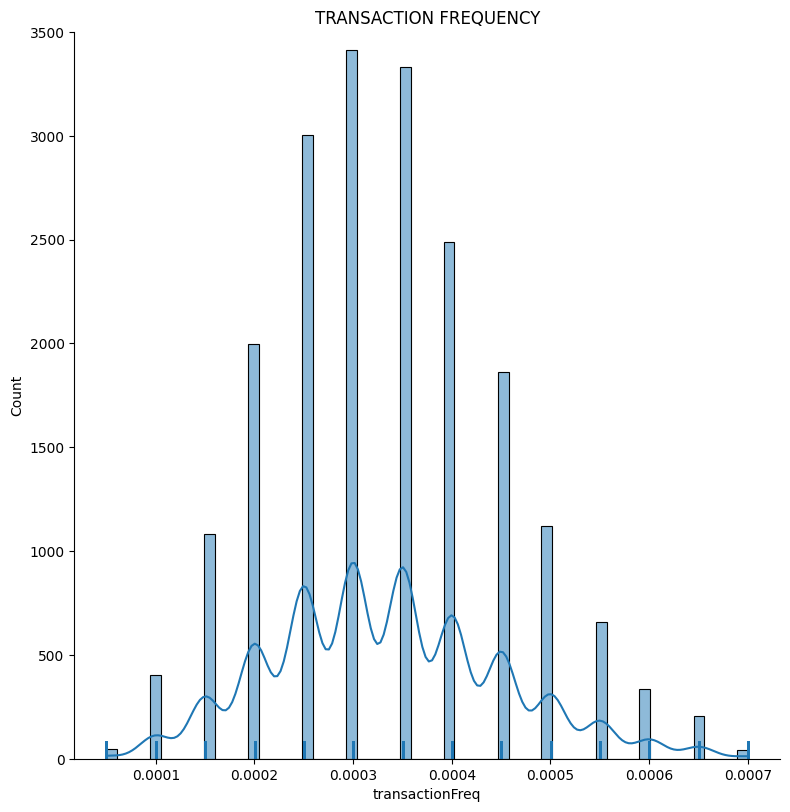

In [111]:
plot1 = sns.displot(Transactions['transactionFreq'], rug=True, kde=True, height=8, aspect=1)
plot1.set(ylim=(0, 3500), title='TRANSACTION FREQUENCY')
plt.savefig('TRANSACTION FREQUENCY.png')

In [55]:
#adding the transaction frequency to the oldcustomerlist 
Trans_freq = Transactions.groupby('customer_id')['transactionFreq']
Trans_freq_df = Trans_freq.value_counts()
Trans_freq_df = pd.DataFrame(Trans_freq_df.reset_index(drop=False))
print(Trans_freq_df)

Sprocket_OldCustomers = pd.merge(OldCustomerList, 
                        Trans_freq_df[['transactionFreq', 'customer_id']], 
                        on='customer_id', 
                        how='left')

      customer_id  transactionFreq  count
0             1.0          0.00055     11
1             2.0          0.00015      3
2             3.0          0.00040      8
3             4.0          0.00010      2
4             5.0          0.00030      6
...           ...              ...    ...
3488       3496.0          0.00020      4
3489       3497.0          0.00015      3
3490       3498.0          0.00030      6
3491       3499.0          0.00035      7
3492       3500.0          0.00030      6

[3493 rows x 3 columns]


In [35]:
#statistical component of the dataframe
Sprocket_OldCustomers.describe()

customer_id  past_3_years_bike_related_purchases  \
count  3993.000000                          3993.000000   
mean   2003.530178                            48.872026   
min       1.000000                             0.000000   
25%    1005.000000                            24.000000   
50%    2004.000000                            48.000000   
75%    3002.000000                            73.000000   
max    4000.000000                            99.000000   
std    1153.454676                            28.733328   

                                 DOB       tenure     postcode  \
count                           3993  3993.000000  3993.000000   
mean   1977-08-03 13:02:40.368663616    10.656170  2985.632607   
min              1940-09-22 00:00:00     1.000000  2000.000000   
25%              1968-06-01 00:00:00     6.000000  2200.000000   
50%    1977-08-03 13:02:40.368663552    10.656170  2768.000000   
75%              1986-10-24 00:00:00    15.000000  3750.000000   
max              2002-03-11 00:00:00    22.000000  4883.000000   
std                              NaN     5.595528   844.954295   

       property_valuation          age  transactionFreq  
count           3993.0000  3993.000000      3486.000000  
mean               7.5144    46.881442         0.000286  
min                1.0000    22.280630         0.000050  
25%                6.0000    37.659138         0.000200  
50%                8.0000    46.880219         0.000300  
75%               10.0000    56.054757         0.000350  
max               12.0000    83.745380         0.000700  
std                2.8253    12.438052         0.000116

In [114]:
# structure of the dataframe
Sprocket_OldCustomers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3993 entries, 0 to 3992
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3993 non-null   float64       
 1   first_name                           3993 non-null   object        
 2   last_name                            3993 non-null   object        
 3   gender                               3993 non-null   object        
 4   past_3_years_bike_related_purchases  3993 non-null   float64       
 5   DOB                                  3993 non-null   datetime64[ns]
 6   job_title                            3993 non-null   object        
 7   job_industry_category                3993 non-null   object        
 8   wealth_segment                       3993 non-null   object        
 9   deceased_indicator                   3993 non-null   object        
 10  owns_car    

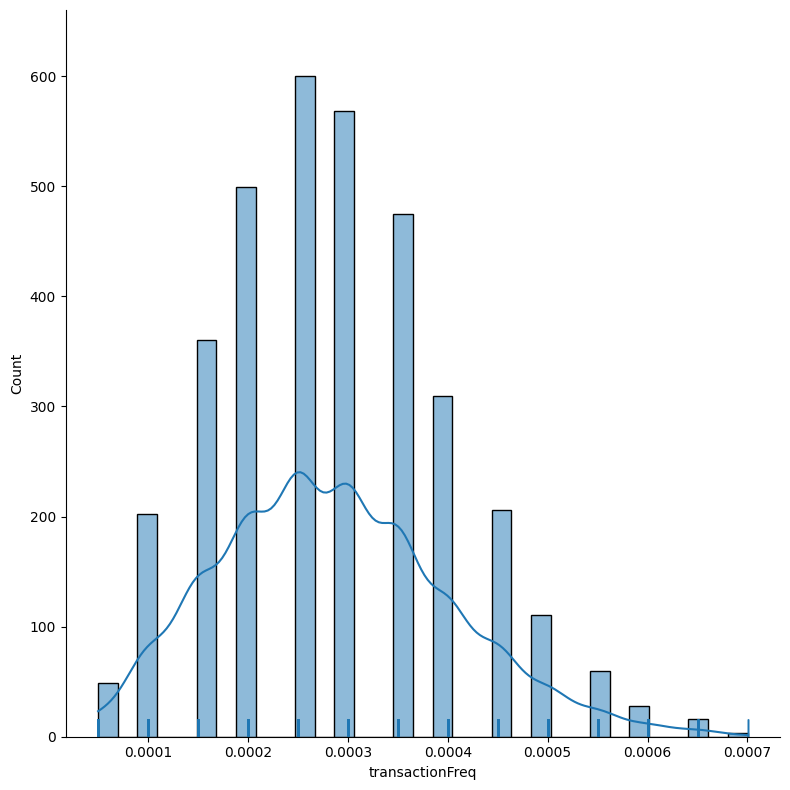

In [36]:
# numbber of unique customer_id for each transaction frequency
sns.displot(Sprocket_OldCustomers.transactionFreq, rug=True, kde=True, height=8, aspect=1)

In [37]:
Sprocket_OldCustomers.transactionFreq.value_counts()

transactionFreq
0.00025    600
0.00030    568
0.00020    499
0.00035    475
0.00015    360
0.00040    309
0.00045    206
0.00010    202
0.00050    111
0.00055     60
0.00005     49
0.00060     28
0.00065     16
0.00070      3
Name: count, dtype: int64

In [67]:
#Segmentation and profiling of customers in the high transaction frequency
cond1 = np.isclose(Sprocket_OldCustomers.transactionFreq, 0.00070, atol=1e-6)
seg_profile1 = Sprocket_OldCustomers.loc[cond1]

cond2 = np.isclose(Sprocket_OldCustomers.transactionFreq, 0.00065, atol=1e-6)
seg_profile2 = Sprocket_OldCustomers.loc[cond2]

cond3 = np.isclose(Sprocket_OldCustomers.transactionFreq, 0.00060, atol=1e-6)
seg_profile3 = Sprocket_OldCustomers.loc[cond3]

cond4 = np.isclose(Sprocket_OldCustomers.transactionFreq, 0.00055, atol=1e-6)
seg_profile4 = Sprocket_OldCustomers.loc[cond4]

cond5 = np.isclose(Sprocket_OldCustomers.transactionFreq, 0.00050, atol=1e-6)
seg_profile5 = Sprocket_OldCustomers.loc[cond5]

Text(0.5, 1.0, '0.00070 transaction frequency')

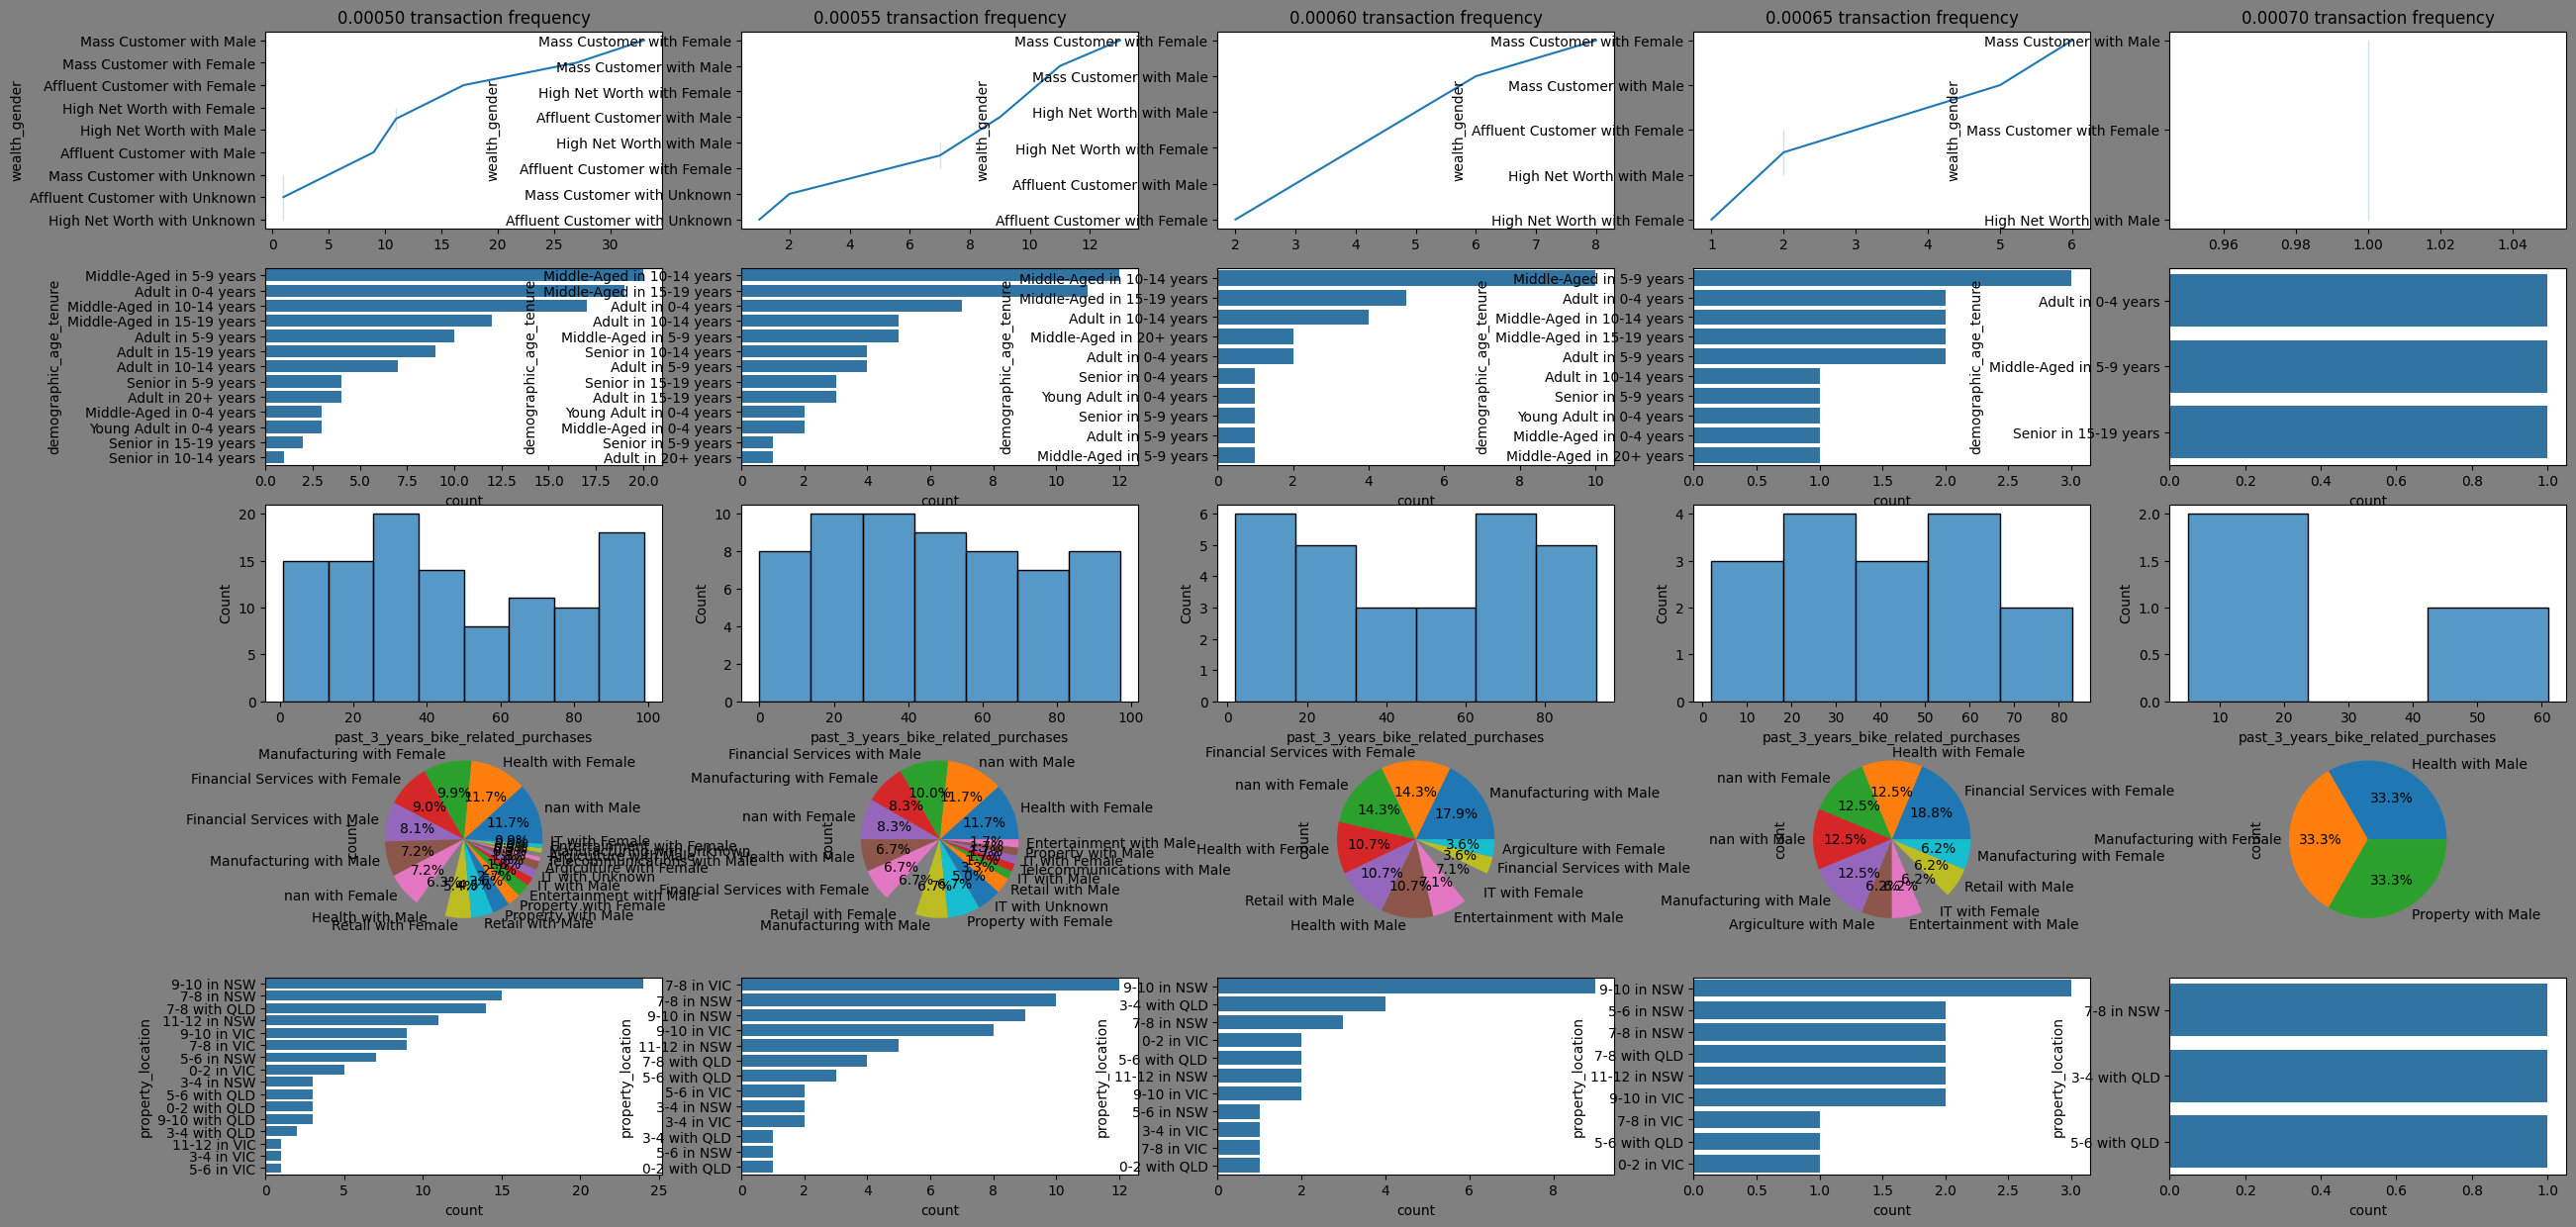

In [69]:
#Segmentation and profiling data analysis visualization

plot_objects = plt.subplots(nrows=5, ncols=5, figsize=(30, 15), dpi=100, facecolor='Grey', edgecolor='white')
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15), (ax16, ax17, ax18, ax19, ax20), (ax21, ax22, ax23, ax24, ax25)) = plot_objects

#data visualization at (0.00050) transaction frequency
sns.lineplot(x=seg_profile5.wealth_gender.value_counts().values, y=seg_profile5.wealth_gender.value_counts().index, ax=ax1)
sns.barplot(seg_profile5.demographic_age_tenure.value_counts(), orient='h', ax=ax6)
sns.histplot(seg_profile5.past_3_years_bike_related_purchases, ax=ax11)
seg_profile5.job_gender.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax16)
sns.barplot(seg_profile5.property_location.value_counts(), orient='h', ax=ax21)

#data visualization at (0.00055) transaction frequency
sns.lineplot(x=seg_profile4.wealth_gender.value_counts().values, y=seg_profile4.wealth_gender.value_counts().index, ax=ax2)
sns.barplot(seg_profile4.demographic_age_tenure.value_counts(), orient='h', ax=ax7)
sns.histplot(seg_profile4.past_3_years_bike_related_purchases, ax=ax12)
seg_profile4.job_gender.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax17)
sns.barplot(seg_profile4.property_location.value_counts(), orient='h', ax=ax22)


#data visualization at (0.00060) transaction frequency
sns.lineplot(x=seg_profile3.wealth_gender.value_counts().values, y=seg_profile3.wealth_gender.value_counts().index, ax=ax3)
sns.barplot(seg_profile3.demographic_age_tenure.value_counts(), orient='h', ax=ax8)
sns.histplot(seg_profile3.past_3_years_bike_related_purchases, ax=ax13)
seg_profile3.job_gender.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax18)
sns.barplot(seg_profile3.property_location.value_counts(), orient='h', ax=ax23)

#data visualization at (0.00065) transaction frequency
sns.lineplot(x=seg_profile2.wealth_gender.value_counts().values, y=seg_profile2.wealth_gender.value_counts().index, ax=ax4)
sns.barplot(seg_profile2.demographic_age_tenure.value_counts(), orient='h', ax=ax9)
sns.histplot(seg_profile2.past_3_years_bike_related_purchases, ax=ax14)
seg_profile2.job_gender.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax19)
sns.barplot(seg_profile2.property_location.value_counts(), orient='h', ax=ax24)

#data visualization at (0.00070) transaction frequency
sns.lineplot(x=seg_profile1.wealth_gender.value_counts().values, y=seg_profile1.wealth_gender.value_counts().index, ax=ax5)
sns.barplot(seg_profile1.demographic_age_tenure.value_counts(), orient='h', ax=ax10)
sns.histplot(seg_profile1.past_3_years_bike_related_purchases, ax=ax15)
seg_profile1.job_gender.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax20)
sns.barplot(seg_profile1.property_location.value_counts(), orient='h', ax=ax25)

ax1.set_title('0.00050 transaction frequency')
ax2.set_title('0.00055 transaction frequency')
ax3.set_title('0.00060 transaction frequency')
ax4.set_title('0.00065 transaction frequency')
ax5.set_title('0.00070 transaction frequency')

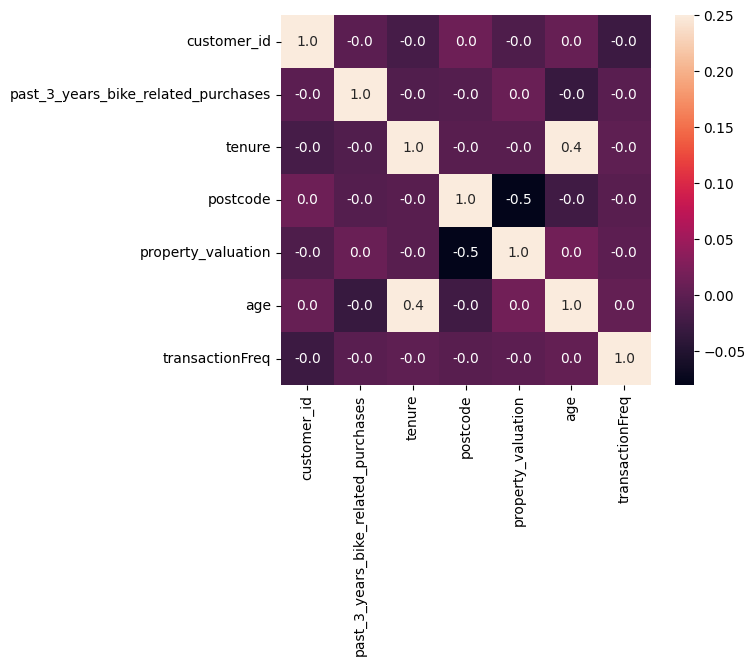

In [56]:
#Sprocket old customers correlation matrix
Sprocket_OldCustomers_numeric = Sprocket_OldCustomers.select_dtypes(['int64', 'float64'])

correlation_matrix = Sprocket_OldCustomers_numeric.corr() 
sns.heatmap(correlation_matrix, annot=True,  fmt=".1f", square=True, vmin=-0.08, vmax=0.25)
plt.show()

<Axes: >

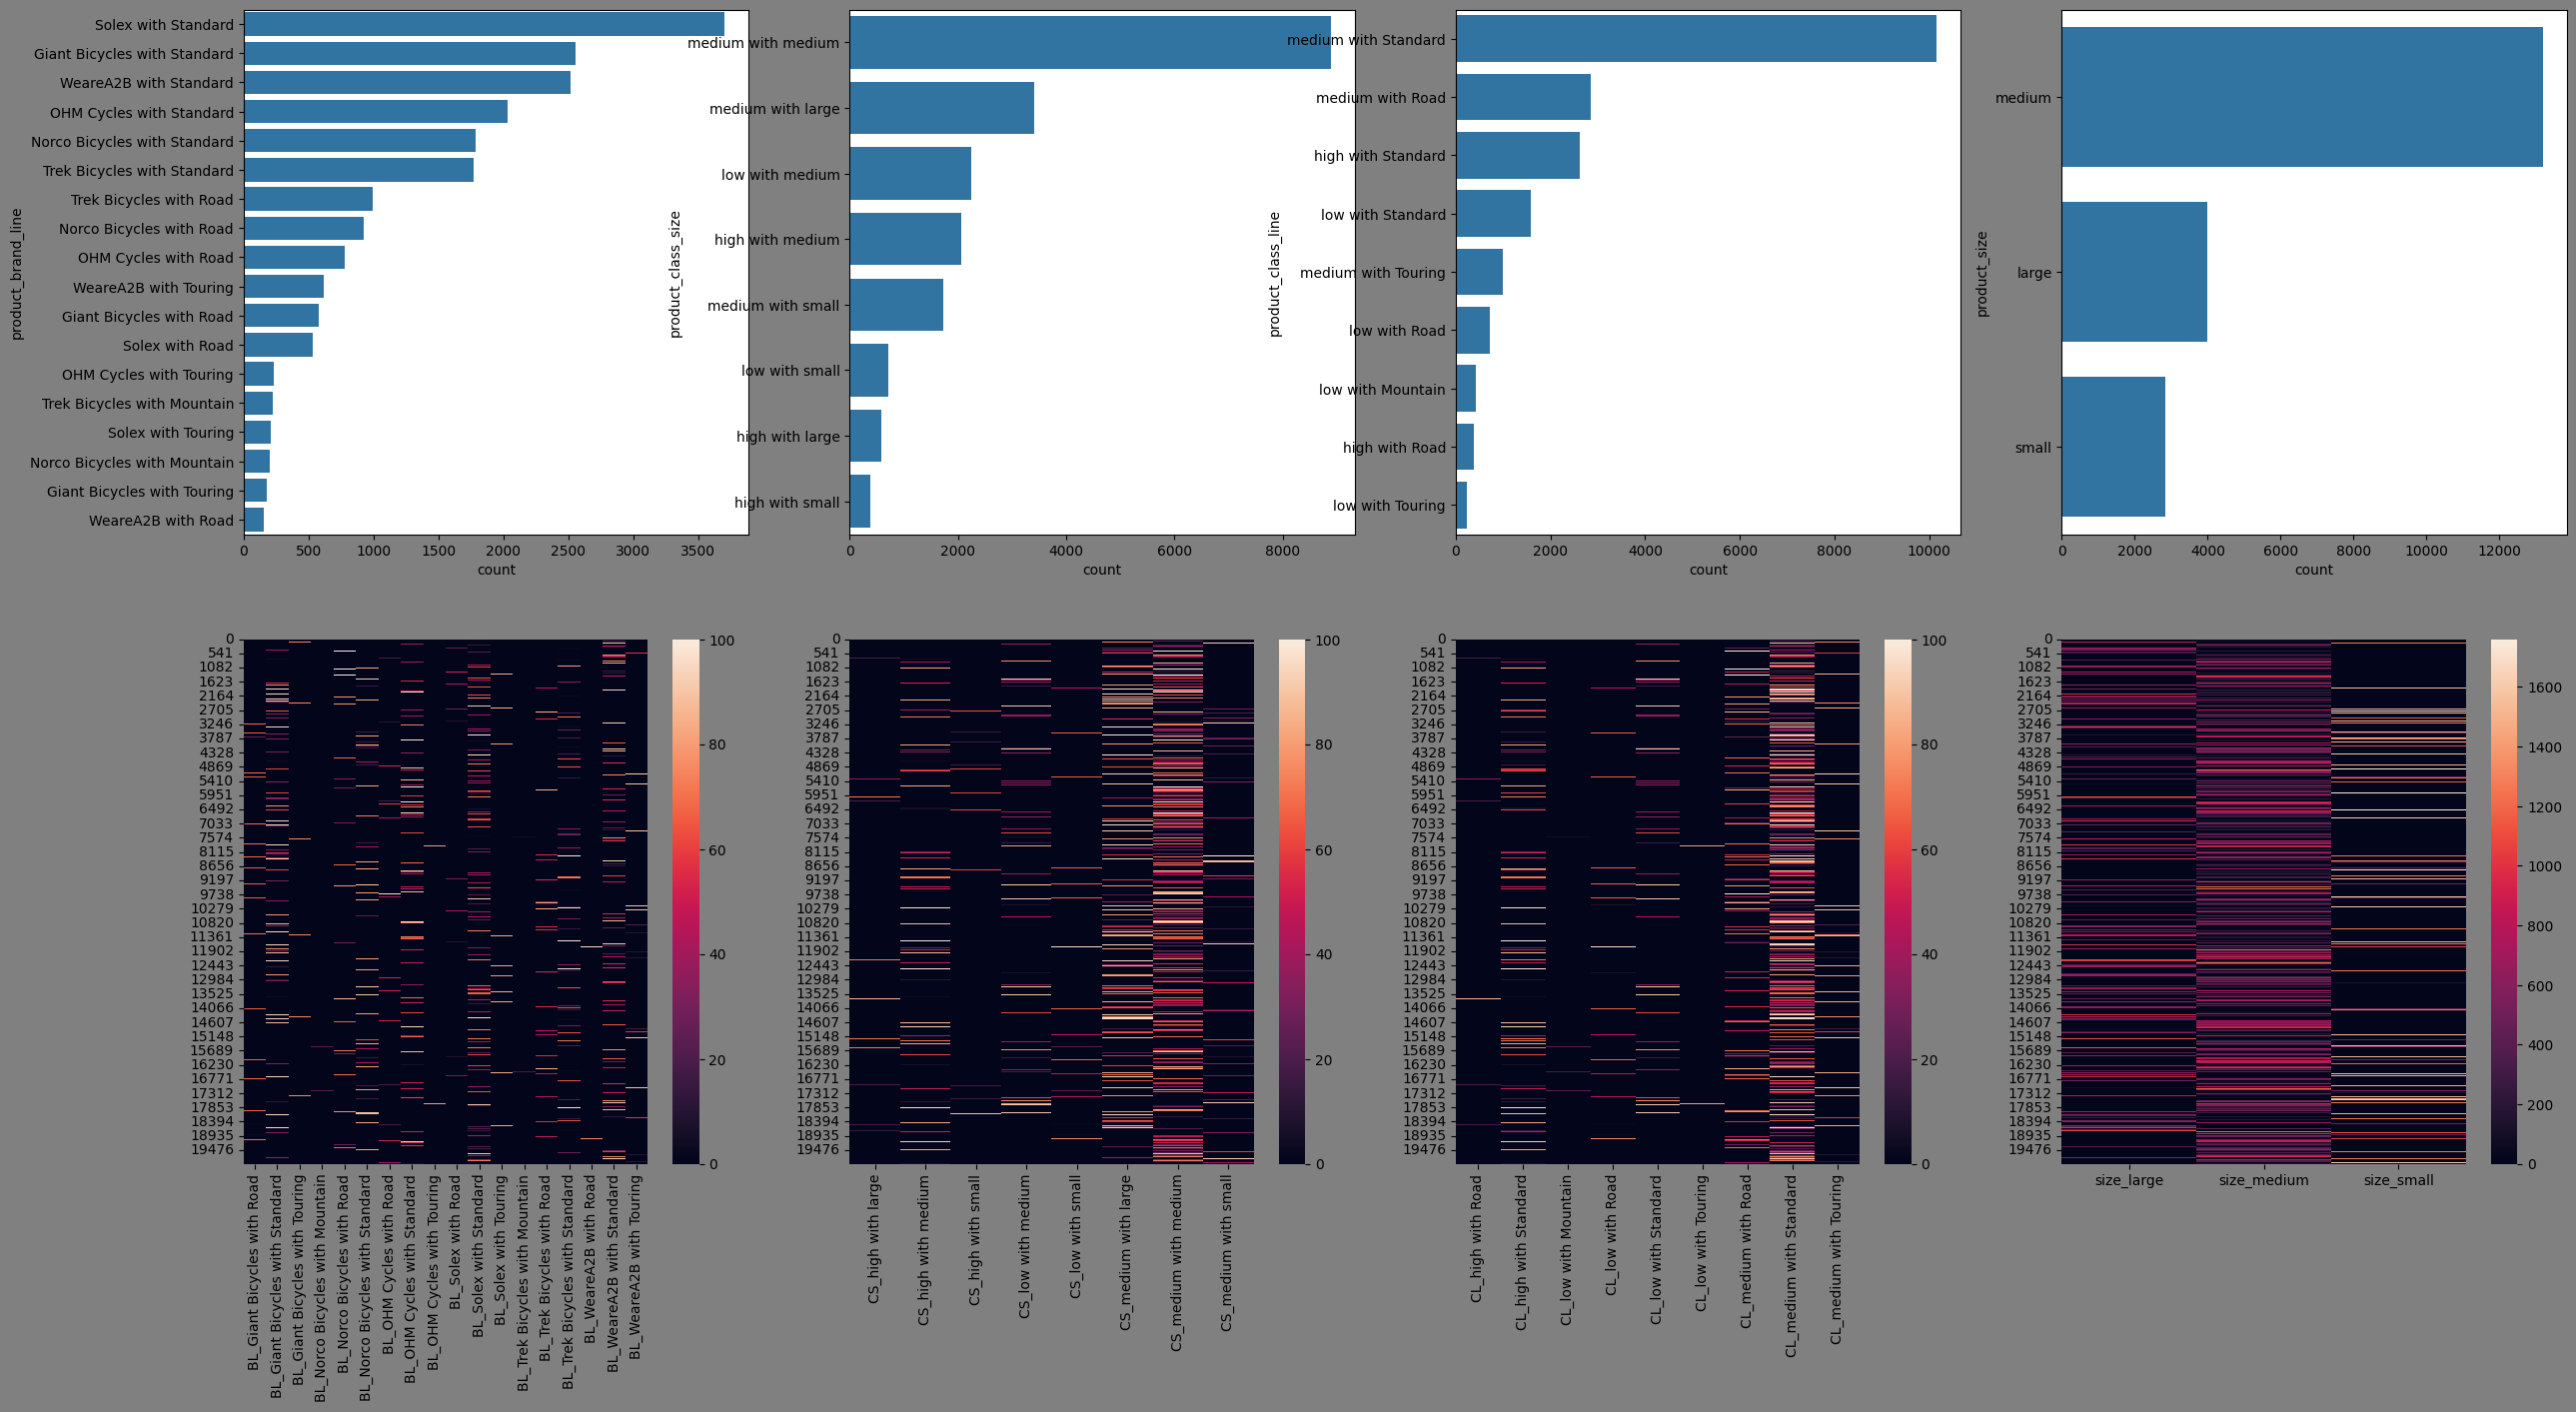

In [119]:
#product_id correlation with features (X_1, X_3 and X_4)
plot_objects = plt.subplots(nrows=2, ncols=4, figsize=(30, 15), dpi=100, facecolor='Grey', edgecolor='white')
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plot_objects

sns.barplot(Transactions.product_brand_line.value_counts(), orient='h', ax=ax1)
sns.barplot(Transactions.product_class_size.value_counts(), orient='h', ax=ax2)
sns.barplot(Transactions.product_class_line.value_counts(), orient='h', ax=ax3)
sns.barplot(Transactions.product_size.value_counts(), orient='h', ax=ax4)
sns.heatmap(X_1, ax=ax5)
sns.heatmap(X_3, ax=ax6)
sns.heatmap(X_4, ax=ax7)


## MODEL DEVELOPMENT AND EVAULATION.

In [120]:
#filtering out customer id with no transaction frequency
cond = Sprocket_OldCustomers.transactionFreq.isnull()
Sprocket_cus_without_transaction = Sprocket_OldCustomers.loc[cond]
check = Sprocket_cus_without_transaction.customer_id
cond = Transactions.customer_id.isin(check)
print(cond.sum())
check_df = Transactions.loc[cond]
check_df.info()

0
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   transaction_id                   0 non-null      float64       
 1   product_id                       0 non-null      float64       
 2   customer_id                      0 non-null      float64       
 3   transaction_date                 0 non-null      datetime64[ns]
 4   online_order                     0 non-null      float64       
 5   order_status                     0 non-null      object        
 6   brand                            0 non-null      object        
 7   product_line                     0 non-null      object        
 8   product_class                    0 non-null      object        
 9   product_size                     0 non-null      object        
 10  list_price                       0 non-null      float64       
 11  standard

In [58]:
#filtering customers with transaction frequency
Sprocket_OldCus_with_transaction = Sprocket_OldCustomers.dropna(subset=['transactionFreq'])
Sprocket_OldCus_with_transaction.set_index('customer_id', inplace=True)
Sprocket_OldCus_with_transaction.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3486 entries, 1.0 to 3500.0
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           3486 non-null   object        
 1   last_name                            3486 non-null   object        
 2   gender                               3486 non-null   object        
 3   past_3_years_bike_related_purchases  3486 non-null   float64       
 4   DOB                                  3486 non-null   datetime64[ns]
 5   job_title                            3486 non-null   object        
 6   job_industry_category                3486 non-null   object        
 7   wealth_segment                       3486 non-null   object        
 8   deceased_indicator                   3486 non-null   object        
 9   owns_car                             3486 non-null   object        
 10  tenure       

In [59]:
NewCustomerList_predictors = NewCustomerList.copy()
NewCustomerList_predictors['DOB'] = (pd.to_datetime(NewCustomerList_predictors['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
X_test = NewCustomerList_predictors.copy()

#loading the y dot notation and the X features
y = Sprocket_OldCus_with_transaction.transactionFreq
Sprocket_OldCus_with_transaction_predictors = Sprocket_OldCus_with_transaction.drop(['transactionFreq'], axis=1)
Sprocket_OldCus_with_transaction_predictors['DOB'] = (pd.to_datetime(Sprocket_OldCus_with_transaction_predictors['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
X = Sprocket_OldCus_with_transaction_predictors.copy()

In [60]:
#cardinality of categorical variables in the new customer list
print('X_test', '\n', X_test.select_dtypes('object').nunique())

X_test 
 first_name                     927
last_name                      946
gender                           3
job_title                      183
job_industry_category            9
wealth_segment                   3
deceased_indicator               1
owns_car                         2
address                        984
state                            3
country                          1
tenure_category                  5
age_category                     4
demographic_age_tenure          18
wealth_assets                    6
wealth_gender                    9
property_valuation_category      6
property_location               18
wealth_assests_job              54
job_gender                      23
dtype: int64


In [62]:
#cardinality of categorical variables in the old customer list
print('X', '\n', X.select_dtypes('object').nunique())

X 
 first_name                     2832
last_name                      3260
gender                            3
job_title                       195
job_industry_category             9
wealth_segment                    3
deceased_indicator                2
owns_car                          2
address                        3484
state                             3
country                           1
tenure_category                   5
age_category                      4
demographic_age_tenure           15
wealth_assets                     6
wealth_gender                     9
property_valuation_category       6
property_location                18
wealth_assests_job               54
job_gender                       24
dtype: int64


In [63]:
object_cols = [cname for cname in X.columns if X[cname].nunique() < 56 and 
                        X[cname].dtype == "object"]

# Columns that can be safely ordinal encodaaed
good_label_cols = [col for col in object_cols if 
                   set(X[col]).issubset(set(X_test[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['gender', 'job_industry_category', 'wealth_segment', 'owns_car', 'state', 'country', 'tenure_category', 'age_category', 'wealth_assets', 'wealth_gender', 'property_valuation_category', 'property_location', 'wealth_assests_job']

Categorical columns that will be dropped from the dataset: ['deceased_indicator', 'job_gender', 'demographic_age_tenure']


In [64]:
#model validation
#loading the y dot notation and the X features

y = Sprocket_OldCus_with_transaction.transactionFreq
Sprocket_OldCus_with_transaction_predictors = Sprocket_OldCus_with_transaction.drop(['transactionFreq', 'deceased_indicator', 'job_gender', 'demographic_age_tenure', 'country'], axis=1)
Sprocket_OldCus_with_transaction_predictors['DOB'] = (pd.to_datetime(Sprocket_OldCus_with_transaction_predictors['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
X = Sprocket_OldCus_with_transaction_predictors.copy()


X_train, X_valid, y_train, y_valid = train_test_split( X, y, train_size=0.8, test_size=0.2, random_state=0)


categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 56 and 
                        X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

my_cols = categorical_cols + numerical_cols
X_train = X_train[my_cols].copy()
X_valid = X_valid[my_cols].copy()

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('my_imputer', SimpleImputer(strategy='most_frequent')),
    ('my_ordinalencoder', OrdinalEncoder())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model = RandomForestRegressor(random_state=0)

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
model_frequency = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, model_frequency)
print('MAE:', score)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'model__n_estimators': [200, 400, 600],
    'model__max_features': ['sqrt', 'log2'],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(my_pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Predictions with the best model
model_frequency_best = best_model.predict(X_valid)

# Evaluate the best model
best_score = mean_absolute_error(y_valid, model_frequency_best)
print('Best MAE:', best_score)
print('Best Parameters:', grid_search.best_params_)

MAE: 9.533163498880133e-05
Best MAE: 9.222301526513897e-05
Best Parameters: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 400}


In [68]:
#loading the y dot notation and the X features
y = Sprocket_OldCus_with_transaction.transactionFreq
Sprocket_OldCus_with_transaction_predictors = Sprocket_OldCus_with_transaction.drop(['transactionFreq', 'deceased_indicator', 'job_gender', 'demographic_age_tenure', 'country'], axis=1)
Sprocket_OldCus_with_transaction_predictors['DOB'] = (pd.to_datetime(Sprocket_OldCus_with_transaction_predictors['DOB']) - pd.Timestamp('1900-01-01')) / pd.Timedelta('1D')
X = Sprocket_OldCus_with_transaction_predictors.copy()



categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 56 and 
                        X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]


# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinalencoder', OrdinalEncoder())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model = RandomForestRegressor(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=400,
    random_state=0
)

cross_Pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])


# Compute cross-validation scores
scores = -1 * cross_val_score(cross_Pipeline, X, y,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')



print('Cross validation score for Sprocket_OldCus_with_transaction', scores.mean())


cross_Pipeline.fit(X, y)

Cross validation score for Sprocket_OldCus_with_transaction 9.418267050845353e-05


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['past_3_years_bike_related_purchases',
                                                   'DOB', 'tenure', 'postcode',
                                                   'property_valuation',
                                                   'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender',
                                                   'job_industry_category',
                                                   'wealth_segment', 'owns_car',
                                                   'state', 'tenure_category',
                                                   'age_category',
                                                   'wealth_assets',
                                                   'wealth_gender',
                                                   'property_valuation_category',
                                                   'property_location',
                                                   'wealth_assests_job'])])),
                ('model',
                 RandomForestRegressor(max_depth=10, max_features='sqrt',
                                       min_samples_leaf=4, n_estimators=400,
                                       random_state=0))])

In [48]:
cross_Pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['past_3_years_bike_related_purchases',
                                                   'DOB', 'tenure', 'postcode',
                                                   'property_valuation',
                                                   'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender',
                                                   'job_industry_category',
                                                   'wealth_segment', 'owns_car',
                                                   'state', 'tenure_category',
                                                   'age_category',
                                                   'wealth_assets',
                                                   'wealth_gender',
                                                   'property_valuation_category',
                                                   'property_location',
                                                   'wealth_assests_job'])])),
                ('model',
                 RandomForestRegressor(max_depth=10, max_features='sqrt',
                                       min_samples_leaf=4, n_estimators=400,
                                       random_state=0))])

In [65]:
ouput1= pd.DataFrame({'id': X_valid.index, 'transactionFreq': y_valid, 'model_frequency': model_frequency_best})

In [66]:
ouput1.head()

id  transactionFreq  model_frequency
customer_id                                          
1120.0       1120.0          0.00030         0.000282
2306.0       2306.0          0.00020         0.000291
230.0         230.0          0.00055         0.000267
51.0           51.0          0.00040         0.000310
3118.0       3118.0          0.00045         0.000284

T-statistic: -0.9418622785744097, p-value: 0.3464263449041912
R-Squared (R²): -0.06451813912247406


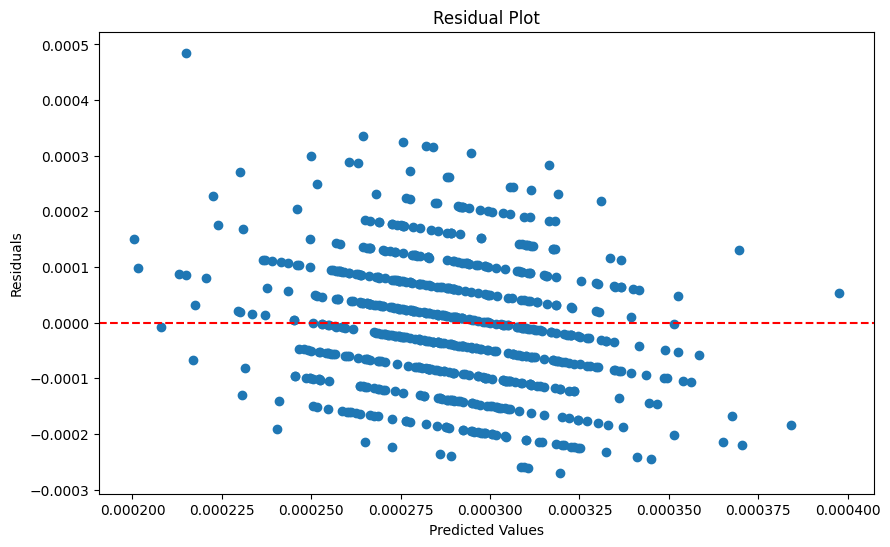

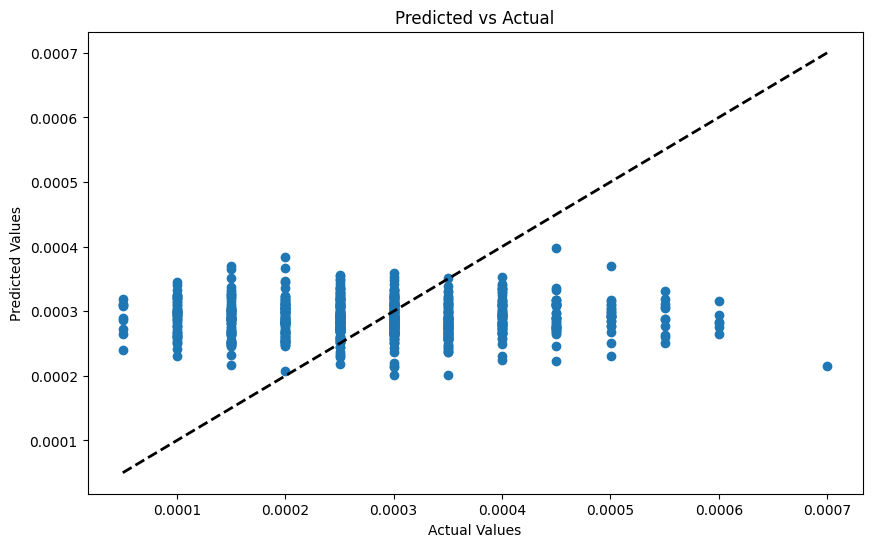

In [67]:
# statistical significance
t_stat, p_value = ttest_ind(ouput1['transactionFreq'], ouput1['model_frequency'])
print(f'T-statistic: {t_stat}, p-value: {p_value}')

# Calculating R²
r2 = r2_score(y_valid, model_frequency)
print('R-Squared (R²):', r2)

# Residuals
residuals = y_valid - model_frequency

# Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(model_frequency, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Predicted vs Actual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, model_frequency)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual')
plt.show()

In [69]:
new_transactionfreq = cross_Pipeline.predict(X_test)

In [70]:
output2 = pd.DataFrame({'id': X_test.index, 'transactionFreq': new_transactionfreq})
output2.head()

id  transactionFreq
0   0         0.000291
1   1         0.000281
2   2         0.000264
3   3         0.000275
4   4         0.000278

In [71]:
Sprocket_NewCustomers = pd.merge(NewCustomerList, 
                        output2[['transactionFreq']], 
                        left_index=True, 
                        right_index=True)

In [72]:
Sprocket_NewCustomers.transactionFreq.round(5).value_counts()

transactionFreq
0.00029    322
0.00028    296
0.00030    160
0.00027    101
0.00031     62
0.00032     18
0.00026     16
0.00033      6
0.00034      2
0.00025      1
Name: count, dtype: int64

Text(0.5, 1.0, 'Prediction on New Customer List transaction frequency')

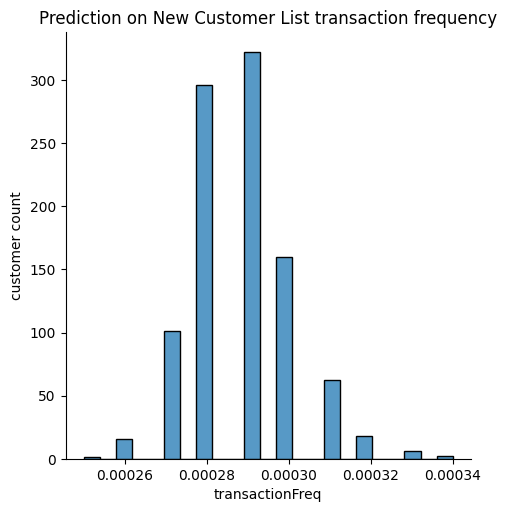

In [73]:
sns.displot(Sprocket_NewCustomers.transactionFreq.round(5))
plt.ylabel('customer count')
plt.title('Prediction on New Customer List transaction frequency')

In [77]:
# Rounding the 'transactionFreq' column to 5 decimal places
Sprocket_NewCustomers['rounded_transaction_freq'] = Sprocket_NewCustomers.transactionFreq.round(5)

Sprocket_NewCustomers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           984 non-null    object        
 1   last_name                            984 non-null    object        
 2   gender                               984 non-null    object        
 3   past_3_years_bike_related_purchases  984 non-null    float64       
 4   DOB                                  984 non-null    datetime64[ns]
 5   job_title                            984 non-null    object        
 6   job_industry_category                984 non-null    object        
 7   wealth_segment                       984 non-null    object        
 8   deceased_indicator                   984 non-null    object        
 9   owns_car                             984 non-null    object        
 10  tenure        

In [84]:
#Segmentation and profiling of customers in the high transaction frequency
cond1 = (Sprocket_NewCustomers.rounded_transaction_freq == 0.00031)
seg_profile1 = Sprocket_NewCustomers.loc[cond1]

cond2 = (Sprocket_NewCustomers.rounded_transaction_freq == 0.00030)
seg_profile2 = Sprocket_NewCustomers.loc[cond2]

cond3 = (Sprocket_NewCustomers.rounded_transaction_freq == 0.00029)
seg_profile3 = Sprocket_NewCustomers.loc[cond3]

cond4 = (Sprocket_NewCustomers.rounded_transaction_freq == 0.00028)
seg_profile4 = Sprocket_NewCustomers.loc[cond4]

cond5 = (Sprocket_NewCustomers.rounded_transaction_freq == 0.00027)
seg_profile5 = Sprocket_NewCustomers.loc[cond5]

Text(0.5, 1.0, '0.00031 transaction frequency')

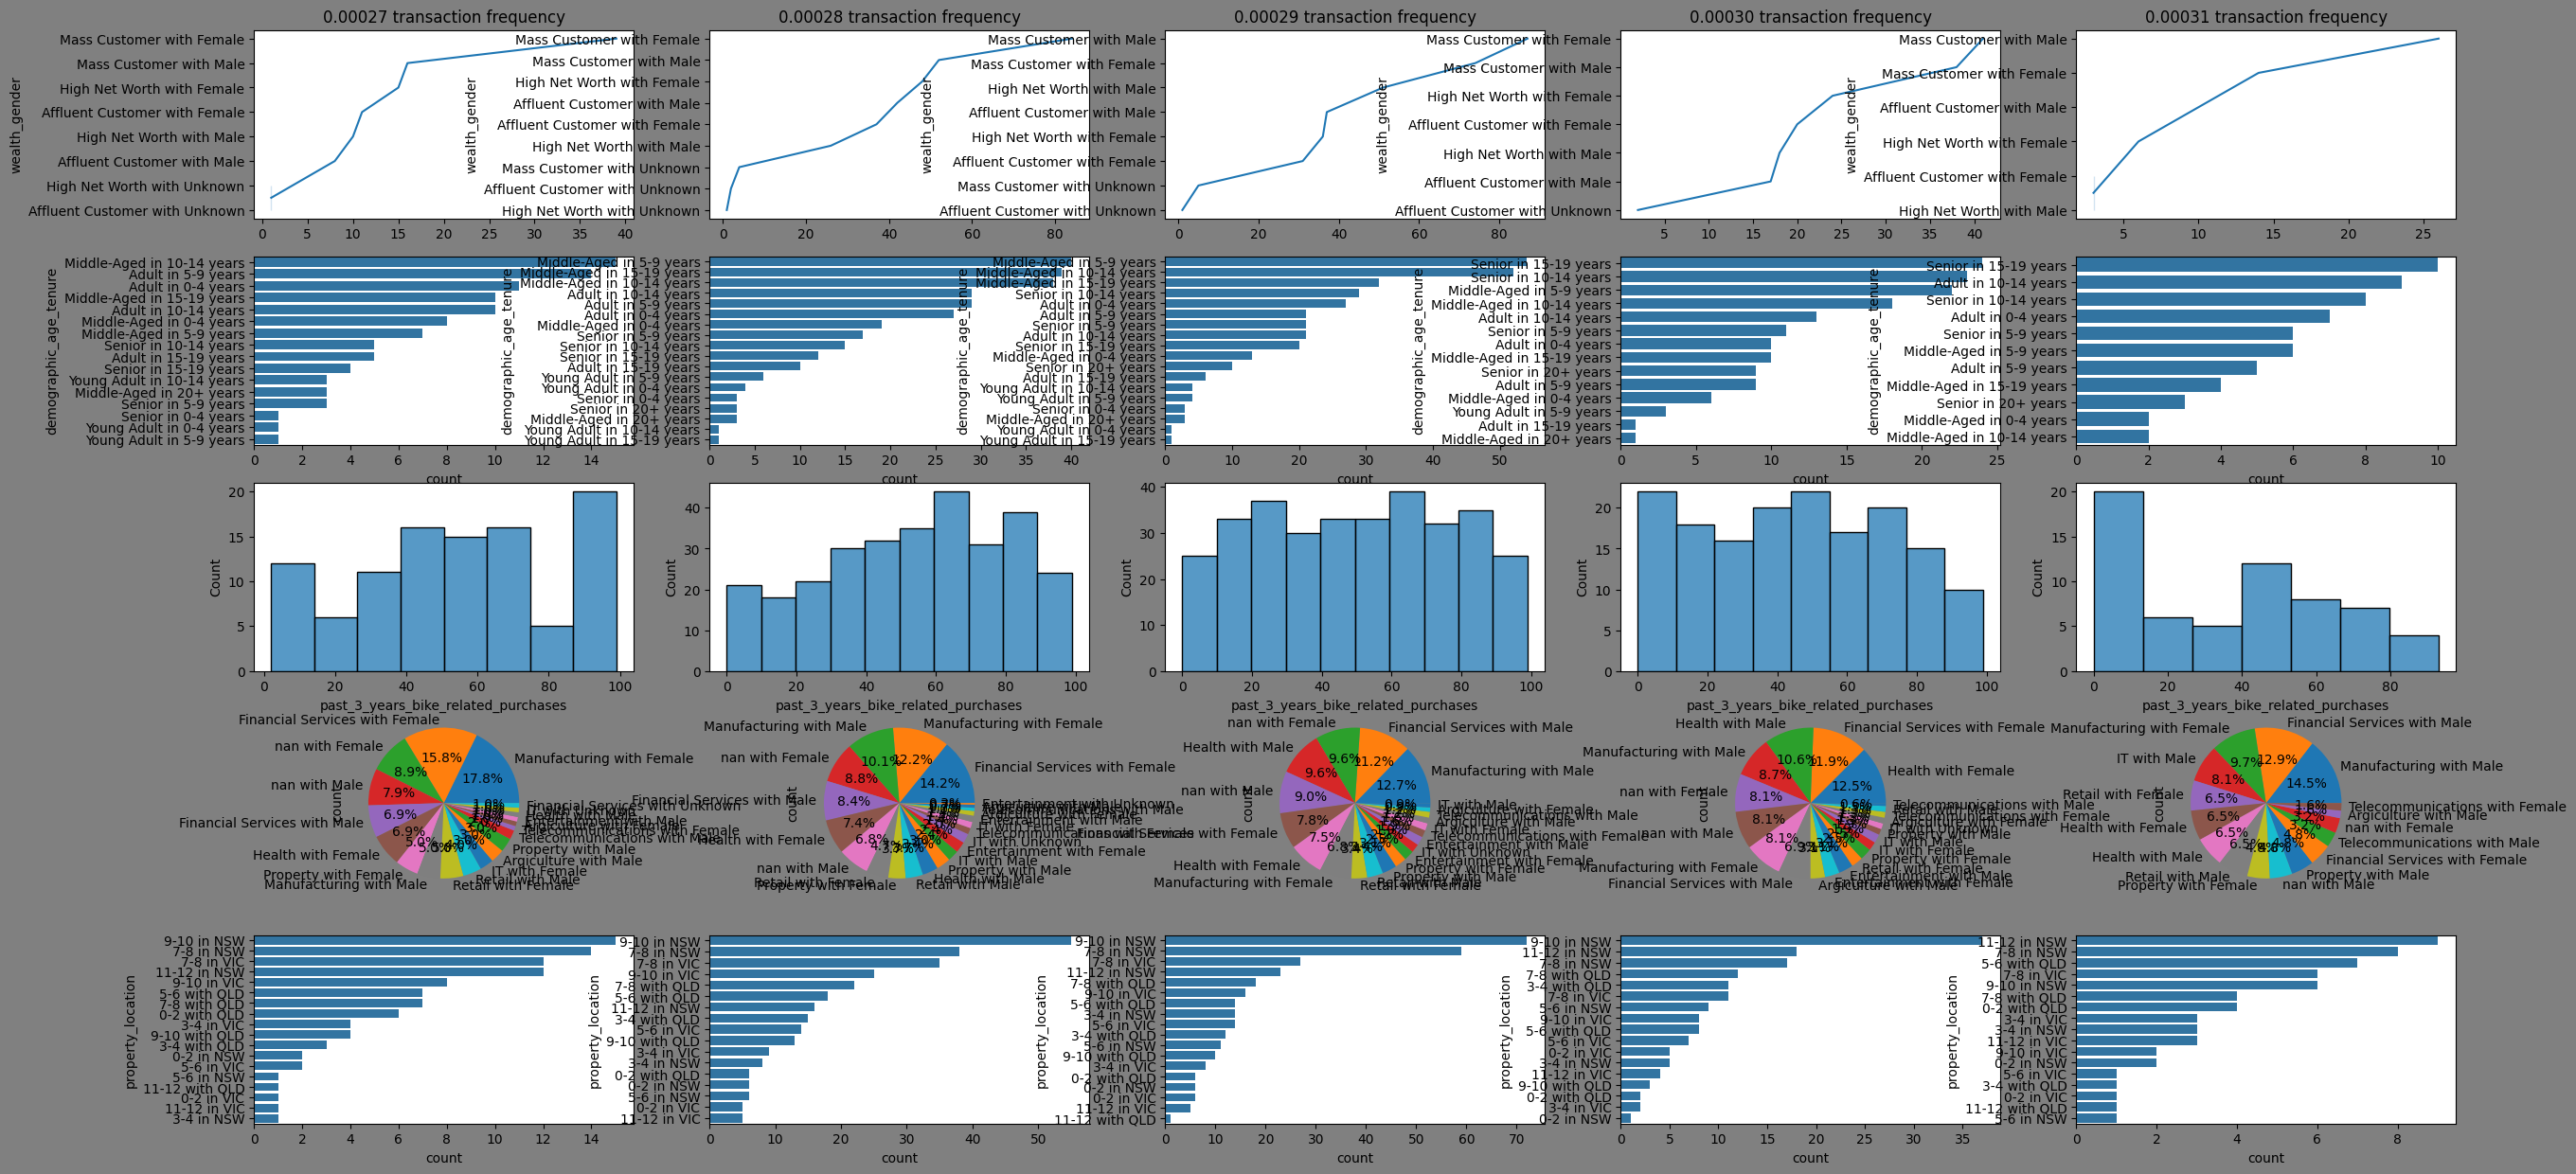

In [85]:
#Segmentation and profiling data analysis visualization

plot_objects = plt.subplots(nrows=5, ncols=5, figsize=(30, 15), dpi=100, facecolor='Grey', edgecolor='white')
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15), (ax16, ax17, ax18, ax19, ax20), (ax21, ax22, ax23, ax24, ax25)) = plot_objects

#data visualization at (0.00050) transaction frequency
sns.lineplot(x=seg_profile5.wealth_gender.value_counts().values, y=seg_profile5.wealth_gender.value_counts().index, ax=ax1)
sns.barplot(seg_profile5.demographic_age_tenure.value_counts(), orient='h', ax=ax6)
sns.histplot(seg_profile5.past_3_years_bike_related_purchases, ax=ax11)
seg_profile5.job_gender.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax16)
sns.barplot(seg_profile5.property_location.value_counts(), orient='h', ax=ax21)

#data visualization at (0.00055) transaction frequency
sns.lineplot(x=seg_profile4.wealth_gender.value_counts().values, y=seg_profile4.wealth_gender.value_counts().index, ax=ax2)
sns.barplot(seg_profile4.demographic_age_tenure.value_counts(), orient='h', ax=ax7)
sns.histplot(seg_profile4.past_3_years_bike_related_purchases, ax=ax12)
seg_profile4.job_gender.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax17)
sns.barplot(seg_profile4.property_location.value_counts(), orient='h', ax=ax22)


#data visualization at (0.00060) transaction frequency
sns.lineplot(x=seg_profile3.wealth_gender.value_counts().values, y=seg_profile3.wealth_gender.value_counts().index, ax=ax3)
sns.barplot(seg_profile3.demographic_age_tenure.value_counts(), orient='h', ax=ax8)
sns.histplot(seg_profile3.past_3_years_bike_related_purchases, ax=ax13)
seg_profile3.job_gender.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax18)
sns.barplot(seg_profile3.property_location.value_counts(), orient='h', ax=ax23)

#data visualization at (0.00065) transaction frequency
sns.lineplot(x=seg_profile2.wealth_gender.value_counts().values, y=seg_profile2.wealth_gender.value_counts().index, ax=ax4)
sns.barplot(seg_profile2.demographic_age_tenure.value_counts(), orient='h', ax=ax9)
sns.histplot(seg_profile2.past_3_years_bike_related_purchases, ax=ax14)
seg_profile2.job_gender.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax19)
sns.barplot(seg_profile2.property_location.value_counts(), orient='h', ax=ax24)

#data visualization at (0.00070) transaction frequency
sns.lineplot(x=seg_profile1.wealth_gender.value_counts().values, y=seg_profile1.wealth_gender.value_counts().index, ax=ax5)
sns.barplot(seg_profile1.demographic_age_tenure.value_counts(), orient='h', ax=ax10)
sns.histplot(seg_profile1.past_3_years_bike_related_purchases, ax=ax15)
seg_profile1.job_gender.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax20)
sns.barplot(seg_profile1.property_location.value_counts(), orient='h', ax=ax25)

ax1.set_title('0.00027 transaction frequency')
ax2.set_title('0.00028 transaction frequency')
ax3.set_title('0.00029 transaction frequency')
ax4.set_title('0.00030 transaction frequency')
ax5.set_title('0.00031 transaction frequency')

In [163]:
cond = (Sprocket_NewCustomers['rounded_transaction_freq'] > 0.00026) & (Sprocket_NewCustomers['rounded_transaction_freq'] < 0.00031)
Trageted_Customer_df = Sprocket_NewCustomers.loc[cond]

In [164]:
Trageted_Customer_df['rounded_transaction_freq'].value_counts()

rounded_transaction_freq
0.00029    330
0.00028    286
0.00030    162
0.00027    104
Name: count, dtype: int64

In [166]:
Trageted_Customer_df.describe()

past_3_years_bike_related_purchases                            DOB  \
count                           882.000000                            882   
mean                             50.733560  1972-02-23 19:39:51.161386992   
min                               0.000000            1939-05-26 00:00:00   
25%                              29.000000            1959-11-23 12:00:00   
50%                              52.000000            1972-08-13 00:00:00   
75%                              72.000000            1982-04-16 00:00:00   
max                              99.000000            2002-02-27 00:00:00   
std                              27.563823                            NaN   

           tenure     postcode  property_valuation         age  \
count  882.000000   882.000000          882.000000  882.000000   
mean    11.327664  3011.639456            7.463719   52.309861   
min      0.000000  2000.000000            1.000000   22.299795   
25%      7.000000  2209.000000            6.000000   42.168378   
50%     11.000000  2782.500000            8.000000   51.841205   
75%     15.000000  3836.000000            9.000000   64.562628   
max     22.000000  4879.000000           12.000000   85.059548   
std      5.025057   846.421251            2.671015   15.907043   

       transactionFreq  rounded_transaction_freq  
count       882.000000                882.000000  
mean          0.000286                  0.000286  
min           0.000265                  0.000270  
25%           0.000280                  0.000280  
50%           0.000286                  0.000290  
75%           0.000293                  0.000290  
max           0.000305                  0.000300  
std           0.000009                  0.000009